## Setup

In [35]:
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm
import statsmodels.tsa as tsa
from statsmodels.regression.linear_model import OLS
import os, sys
path = os.path.abspath(os.path.join('..'))
if path not in sys.path:
    sys.path.append(path)

from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso, Ridge, LassoCV, RidgeCV, LogisticRegression, LinearRegression
from sklearn.model_selection import TimeSeriesSplit, train_test_split, GridSearchCV, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVC

from sklearn.dummy import DummyClassifier, DummyRegressor

from eptest_main import read_ep_data, get_ct_dfs, adjust_ct_dfs, get_rolling_cts, get_interp_swaps
from eptest_main import test_adfuller, RegressionMain, get_norm_cts, get_norm_curve_diffs, get_daily_curve_diffs
from eptest_main import CT_SWAP_MAP, CT_SIZES, COT_COLS, PRICE_DUR_COLS
from Modelling.classification import run_cv, run_cv_weighted, display_cv_metrics, display_is_metrics
from Research.signals import lookback_zscore, zscore_signal, zscore_sizing, generate_pnl, generate_mtm_pnl, generate_pnl_index,\
                            generate_perf_summary, draw_signal_response, generate_exposures

# read the excel data and generate interpolated swaps to use for WN and US contracts
legacy, tff, futures, swaps_raw = read_ep_data()
swaps = get_interp_swaps(swaps_raw)

# Preprocessing + PCA

In [36]:
swaps.head()

,2y,5y,7y,10y,15y,20y,30y,swap_US,25y
2010-01-01,1.4117,2.9684,3.5285,3.9500,4.3458,4.4542,4.5175,4.3458,4.48585
2010-01-04,1.3450,2.9231,3.4801,3.9340,4.3372,4.4431,4.5100,4.3372,4.47655
2010-01-05,1.2968,2.8480,3.3975,3.8550,4.2645,4.3876,4.4590,4.2645,4.42330
2010-01-06,1.2740,2.8858,3.4545,3.9255,4.3355,4.4631,4.5350,4.3355,4.49905
2010-01-07,1.3020,2.9148,3.4765,3.9435,4.3520,4.4770,4.5585,4.3520,4.51775


In [37]:
idx = pd.IndexSlice
futures.loc[:, idx[:, 'PX_LAST']].tail()

ct,TU,FV,TY,US,WN
field,PX_LAST,PX_LAST,PX_LAST,PX_LAST,PX_LAST
2020-10-14,110.437500,125.890625,139.218750,175.37500,220.15625
2020-10-15,110.437500,125.843750,139.125000,175.25000,219.84375
2020-10-16,110.429688,125.820312,139.062500,174.90625,218.93750
2020-10-19,110.425781,125.757812,138.921875,174.50000,218.25000
2020-10-20,110.425781,125.718750,138.703125,173.50000,215.81250


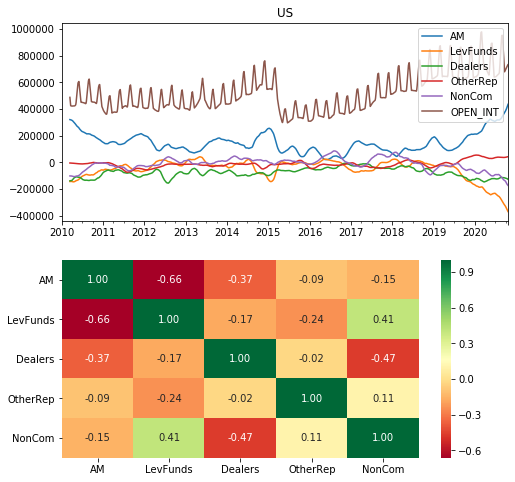

In [38]:
# look at historical CTD mty?
# wish i could get invoice spreads data more easily

# break the data as of Tuesday measurement for initial modeling purposes
ct_dfs = get_ct_dfs(legacy, tff, futures, swaps)
ct = 'US'
ct_dfs[ct].head()
fig, ax = plt.subplots(figsize=(8,8), nrows=2)
sns.heatmap(ct_dfs[ct].loc[:, ['AM', 'LevFunds', 'Dealers', 'OtherRep', 'NonCom']].diff(13).corr(), annot=True, fmt='.2f', cmap='RdYlGn', ax=ax[1])
ct_dfs[ct].loc[:, ['AM', 'LevFunds', 'Dealers', 'OtherRep', 'NonCom', 'OPEN_INT']].rolling(52).mean().plot(ax=ax[0])
ax[0].legend(loc=1)
ax[0].set_title(ct)
plt.show()

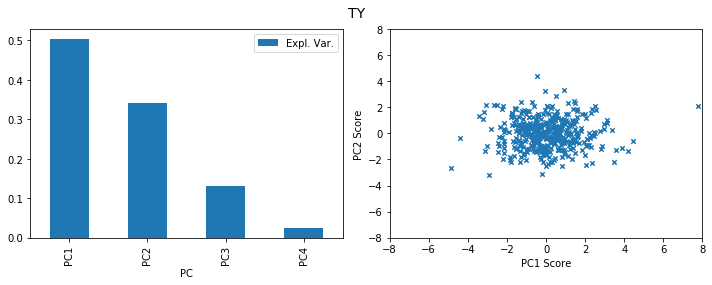

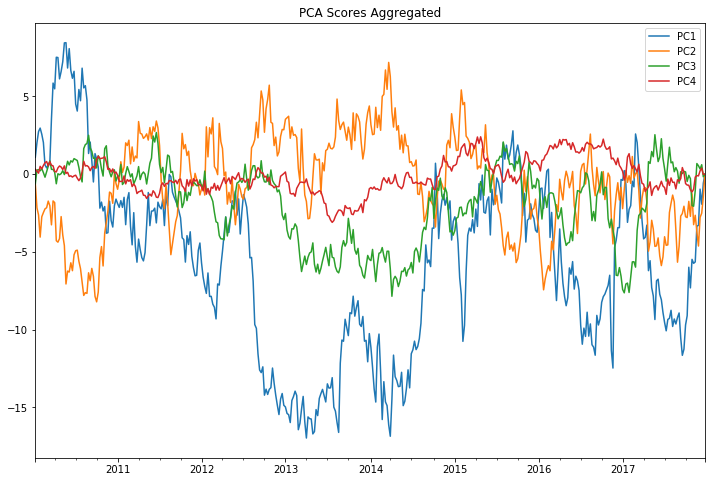

Loadings Matrix:


,AM,LevFunds,Dealers,NonCom
PC1,0.591,-0.649,0.034,-0.479
PC2,-0.426,-0.048,0.809,-0.402
PC3,0.094,-0.468,0.408,0.778
PC4,-0.679,-0.598,-0.421,-0.057


In [39]:
# run PCA see how much variance we can explain by one or two components
is_end_dt = dt.date(2018,1,1)
cols = ['AM', 'LevFunds', 'Dealers', 'NonCom']
ct = 'TY'
prepca_data = ct_dfs[ct].loc[:is_end_dt, cols].asfreq('W-TUE', method='ffill').diff(1).dropna(how='any')
prepca_data = prepca_data.subtract(prepca_data.mean()).divide(prepca_data.std())
prepca_data = prepca_data.dropna(how='any')
pca = PCA()
pca.fit(prepca_data)
pc_cols = ['PC'+str(i+1) for i in np.arange(pca.n_components_)]

exp_var = pd.DataFrame(zip(pca.explained_variance_ratio_, pc_cols), 
                       columns=['Expl. Var.','PC'])

scores = pd.DataFrame(pca.fit_transform(prepca_data), index=prepca_data.index, columns=pc_cols)
loadings = pd.DataFrame(pca.components_, index=['PC'+str(i) for i in np.arange(1,pca.n_components_+1)], columns=cols)
integrated_scores = scores.cumsum()


fig0, ax0 = plt.subplots(figsize=(10,4),ncols=2)
exp_var.plot.bar(x='PC', y='Expl. Var.', ax=ax0[0])
ax0[1].scatter(scores['PC1'].values, scores['PC2'].values, s=20, marker="x")
ax0[1].set_xlim(-8,8)
ax0[1].set_ylim(-8,8)
ax0[1].set_xlabel('PC1 Score')
ax0[1].set_ylabel('PC2 Score')
fig0.suptitle(ct, fontsize=14)
fig0.tight_layout()
fig0.subplots_adjust(top=0.9)

fig, ax = plt.subplots(figsize=(12,8))
integrated_scores.plot(ax=ax)
ax.set_title('PCA Scores Aggregated')
plt.show()
print('Loadings Matrix:') 
loadings.round(3)

C:\Users\Brendan\FinML\MLFin\ExPtTest\eptest_main.py:208: RuntimeWarning: invalid value encountered in sign
  new_df[fwdname + '_sign'] = np.sign(new_df[fwdname])


FV                    tstat          pval
Com_dv01       -6.097722  1.000681e-07
NonCom_dv01    -5.860149  3.425555e-07
NonRep_dv01    -7.307728  1.288308e-10
AM_dv01        -4.538266  1.675945e-04
LevFunds_dv01  -5.260779  6.598606e-06
Dealers_dv01   -5.877427  3.135522e-07
OtherRep_dv01  -5.312513  5.158150e-06
5y             -3.936412  1.782633e-03
5y_lag13       -3.886788  2.134260e-03
5y_lag26       -3.283847  1.561613e-02
5y_fwd1       -22.578942  0.000000e+00
5y_fwd1_sign  -23.161469  0.000000e+00
5y_fwd1_abs   -13.739194  1.102576e-25
TU                    tstat          pval
Com_dv01       -6.751577  2.941915e-09
NonCom_dv01    -6.531390  9.849740e-09
NonRep_dv01    -5.980267  1.845657e-07
AM_dv01        -5.099162  1.407347e-05
LevFunds_dv01  -4.454647  2.372694e-04
Dealers_dv01   -7.434646  6.229483e-11
OtherRep_dv01  -5.726645  6.747233e-07
2y             -3.639614  5.047319e-03
2y_lag13       -3.568056  6.401928e-03
2y_lag26       -2.334131  1.611961e-01
2y_fwd1       -22.1

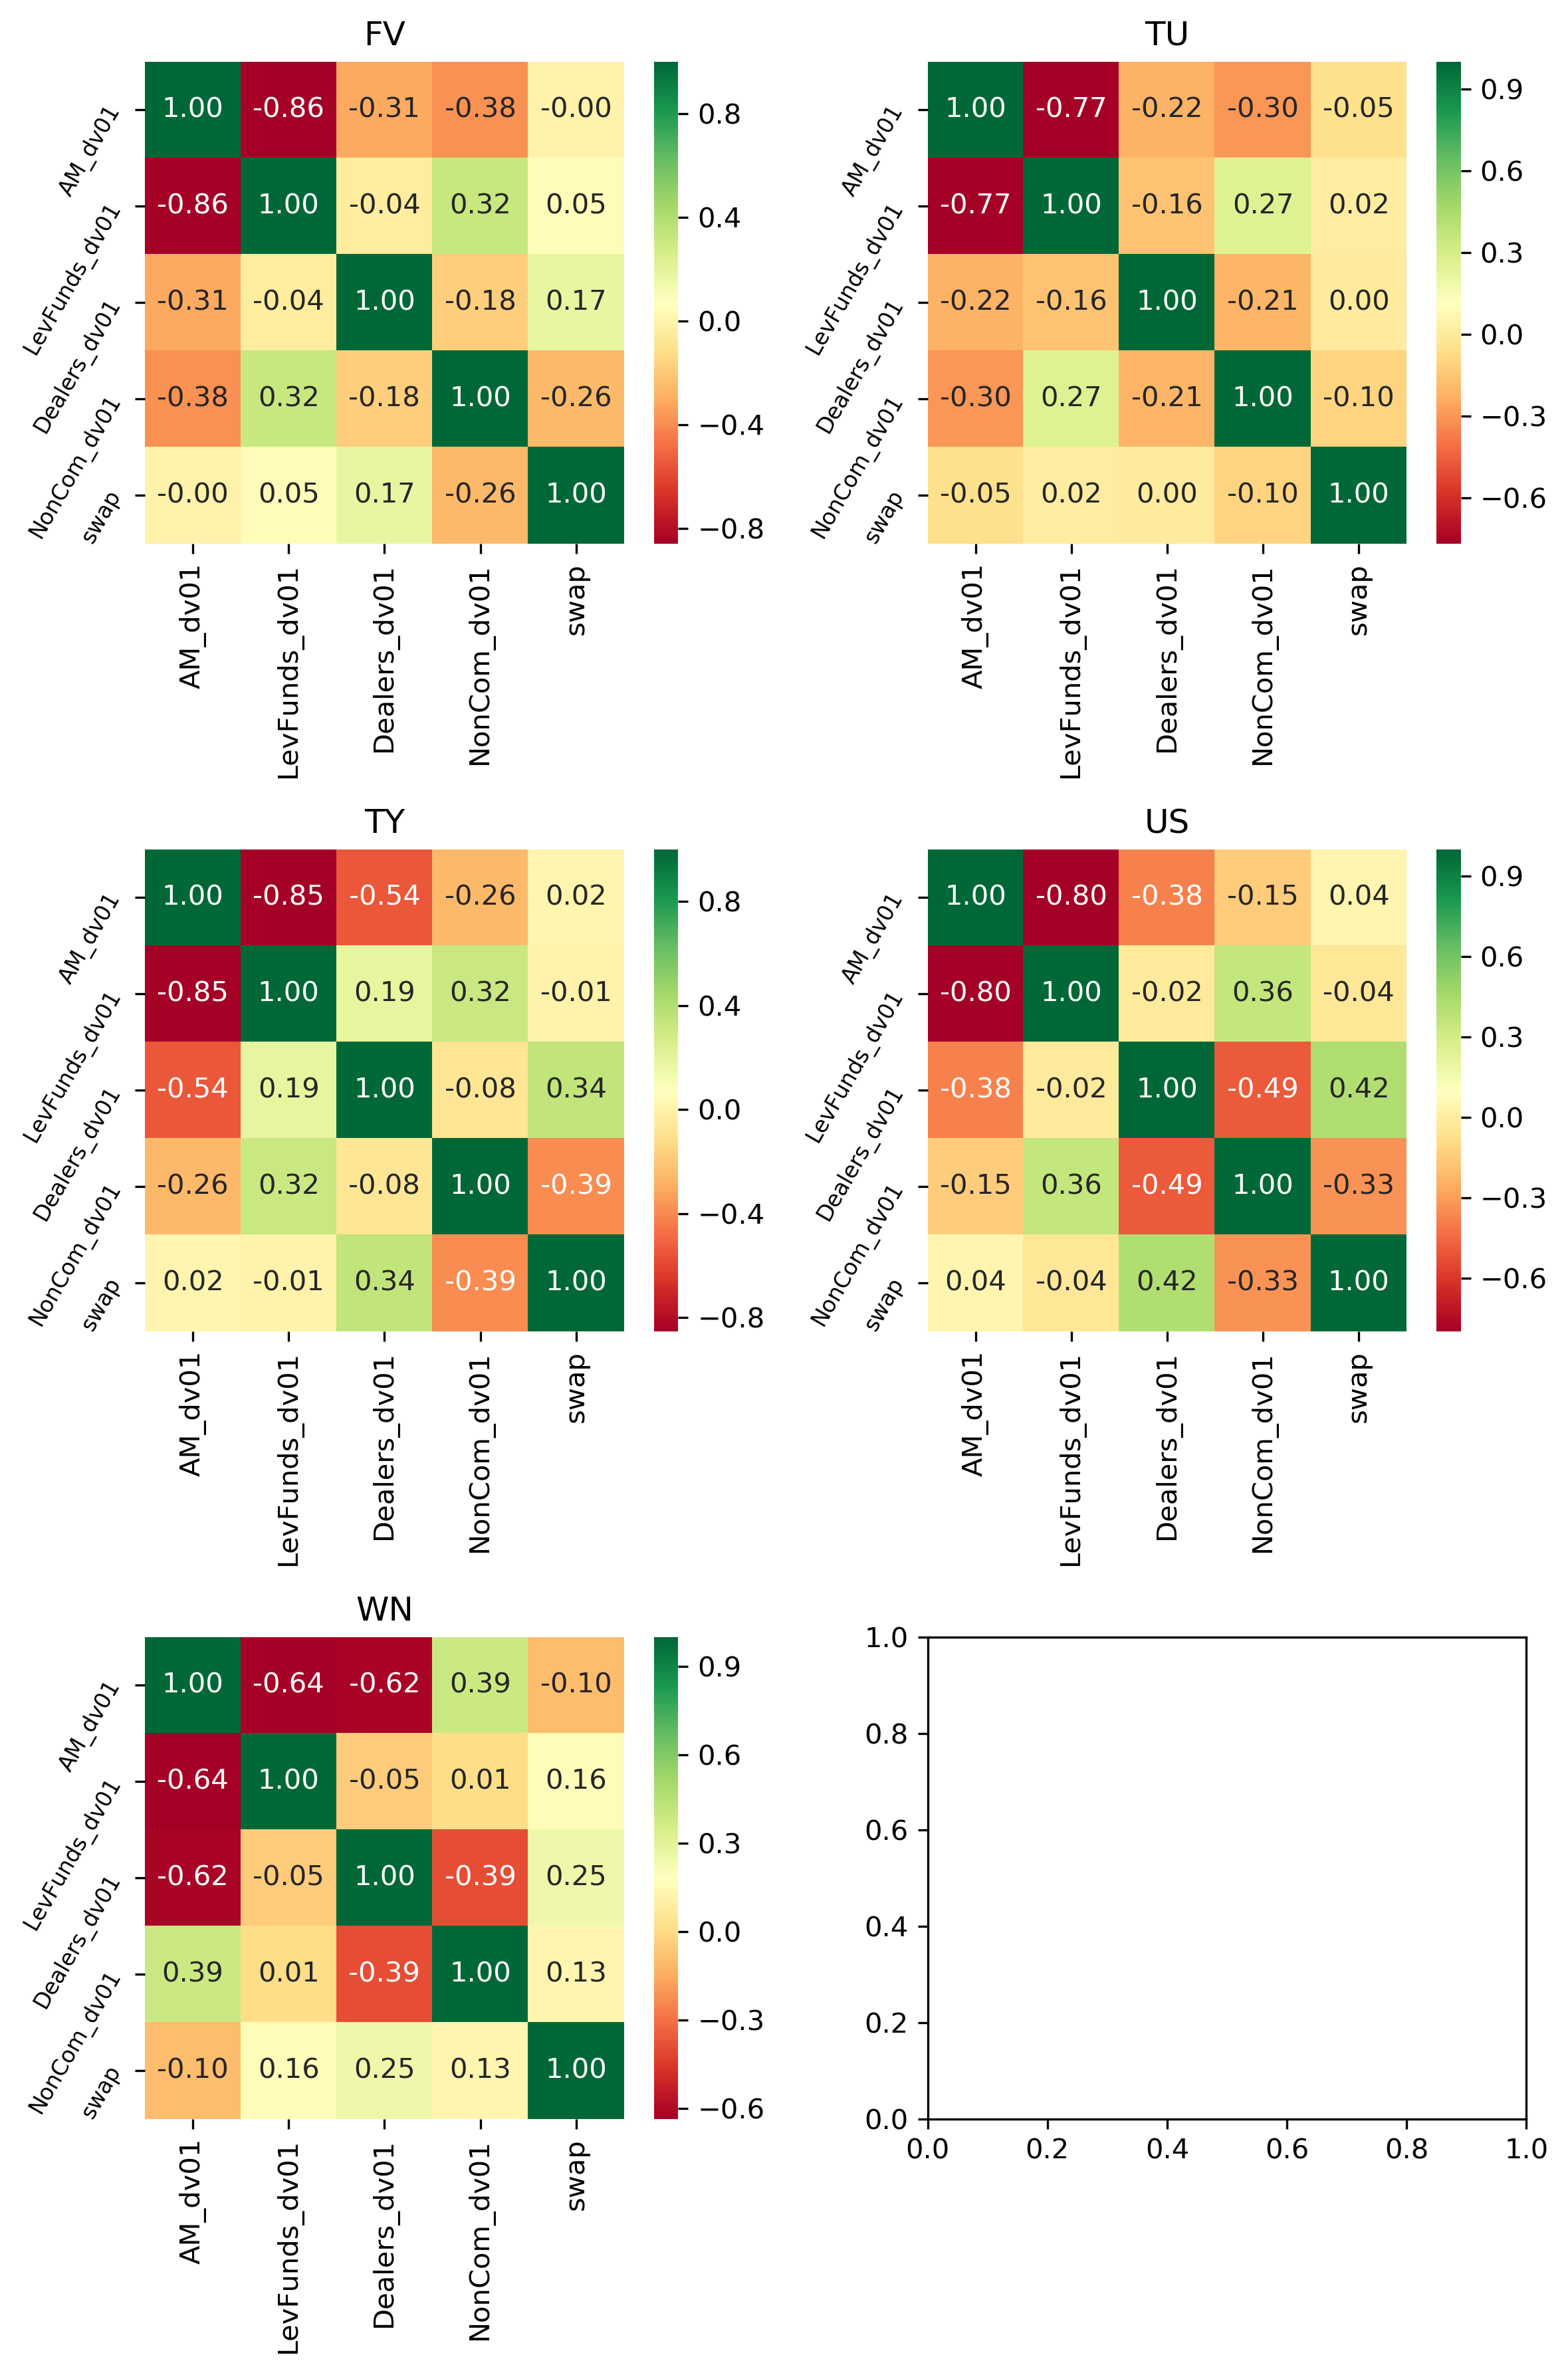

In [40]:
# function to compute dv01 weighted values and shift CoT data 3d forward after
adj_ct_dfs = adjust_ct_dfs(ct_dfs, swaps, oi_avg_len=125)

# resample on Friday's with 'window' sized rolling weekly differences
feat_adj = '_dv01'
window = 13
r = get_rolling_cts(adj_ct_dfs, feat_adj, window=window, swap_chg_lags=[1,2])
is_end_dt = dt.date(2018,1,1)

# determine stationarity of features
# look at correlations
# - Only worth looking at one of Com/NonCom since they're basically just diff sign

corr_feats = ['AM_dv01', 'LevFunds_dv01', 'Dealers_dv01', 'NonCom_dv01']
for k, df in r.items():
    print(k, test_adfuller(df, maxlag=1))
fig, ax = plt.subplots(figsize=(8,12), nrows=3, ncols=2, dpi=300)
for i, (k, df) in enumerate(r.items()):
    col, row = i%2, i//2
    swap_name = CT_SWAP_MAP[k][0]
    data = df.loc[:is_end_dt, np.hstack([corr_feats, swap_name])].rename({swap_name: 'swap'}, axis=1).corr()
    sns.heatmap(data, annot=True, fmt='.2f', cmap='RdYlGn', ax=ax[row][col])
    ax[row][col].set_title(k)
    ax[row][col].set_yticklabels(ax[row][col].get_yticklabels(), rotation = 60, fontsize = 8)
    #ax[row][col].set_xticklabels(ax[row][col].get_xticklabels(), rotation = 30, fontsize = 8)
fig.tight_layout()

plt.show()


# Modelling

## Contemporaneous OLS

In [41]:
# retrieve the data and fit simple OLS on TY data + swap
adj_ct_dfs = adjust_ct_dfs(ct_dfs, swaps, oi_avg_len=125, adj_rpt=False)
ct = 'TY'
swap = CT_SWAP_MAP[ct][0]
is_end_dt = dt.date(2018,1,1)
unadj_feats = ['AM', 'LevFunds', 'Dealers', 'NonCom']
feat_adj = '_dv01'
feats = [x+feat_adj for x in unadj_feats]
# i also looked at PC1-3, not particularly more convincing
#feats = ['PC1', 'PC2', 'PC3']
window = 1
r = get_rolling_cts(adj_ct_dfs, feat_adj, window=window, swap_chg_lags=[1,2], resample_per='W-TUE')
data_clean = r[ct].merge(scores, left_index=True, right_index=True).dropna(how='any')

y = data_clean[swap]
X = data_clean.loc[:is_end_dt, np.hstack([feats, swap+'_lag'+str(window)])]

mod = sm.OLS(y, sm.add_constant(X))
res = mod.fit()
res.summary()


C:\Users\Brendan\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     7y   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     11.55
Date:                Fri, 13 Nov 2020   Prob (F-statistic):           1.89e-10
Time:                        14:14:06   Log-Likelihood:                 382.44
No. Observations:                 414   AIC:                            -752.9
Df Residuals:                     408   BIC:                            -728.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0025      0.005     -0.519      0.604      -0.012       0.007
AM_dv01       -4.361e-10   1.64e-09     -0.267      0.790   -3.65e-09    2.78e-09
LevFunds_dv01  3.407e-09   1.62e-09      2.099      0.036    2.16e-10     6.6e-09
Dealers_dv01   7.967e-09   2.02e-09      3.940      0.000    3.99e-09    1.19e-08
NonCom_dv01    1.846e-10   1.05e-09      0.176      0.860   -1.87e-09    2.24e-09
7y_lag1          -0.0357      0.047     -0.761      0.447      -0.128       0.057
==============================================================================
Omnibus:                       29.354   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.560
Skew:                           0.422   Prob(JB):                     5.23e-13
Kurtosis:                       4.602   Cond. No.                     8.48e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.48e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### TY Lasso

TY 1wk changes


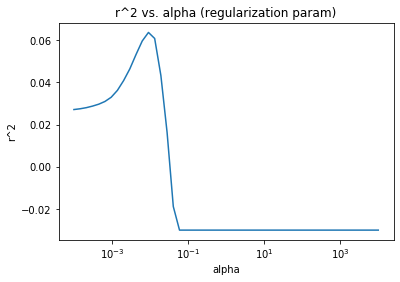

best_score           0.0636896
alpha               0.00910298
best_score_ratio      -2.12482
Name: TY, dtype: object


AM_dv01         -0.015190
LevFunds_dv01    0.000000
Dealers_dv01     0.012419
NonCom_dv01      0.000000
7y_lag1         -0.000000
Name: beta, dtype: float64

In [42]:
# Since we have heavy multicollinearity we need to use some regularization to shrink the betas
# Use Lasso since it will help us with feature selection too
is_start_dt = dt.date(2010, 1, 1)

ct = 'TY'
window = 1
unadj_feat = ['AM', 'LevFunds', 'Dealers', 'NonCom']
model = Lasso()
swap = CT_SWAP_MAP[ct][0]
target = swap
num_features = np.hstack([[a+feat_adj for a in unadj_feat], swap+'_lag'+str(window)])
r = get_rolling_cts(adj_ct_dfs, feat_adj, window=window, swap_chg_lags=[1,2], resample_per='W-TUE')
search, output_df = run_cv(r[ct].dropna(how='any'), ct, feat_adj, is_start_dt, num_features, target, 
                           tss_splits=5, model=model, model_type='Regression', hyperparam_name='alpha',
                            scorer=None, sample_weight=None, max_train_size=208)
print(r'TY {0}wk changes'.format(window))
display_cv_metrics(search, 'alpha', 'r^2', log_scale=True)
print(output_df[['best_score', 'alpha', 'best_score_ratio']])
pd.Series(output_df['beta'], name='beta', index=num_features)

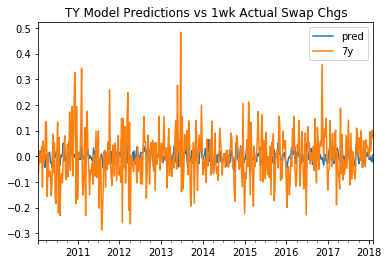

In [43]:
# Plot the model predictions versus actual changes
ty_data = r[ct].dropna(how='any')
X = ty_data.loc[:, num_features]
y = ty_data.loc[:, target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)
pred = pd.Series(search.predict(X_train), index=X_train.index).rename('pred')
fig, ax = plt.subplots()
pred.plot()
y_train.plot()
ax.legend()
ax.set_title('TY Model Predictions vs 1wk Actual Swap Chgs')
plt.show()

## Fwd looking regressions

C:\Users\Brendan\FinML\MLFin\ExPtTest\eptest_main.py:208: RuntimeWarning: invalid value encountered in sign
  new_df[fwdname + '_sign'] = np.sign(new_df[fwdname])


TY 5wk changes vs 20d fwd swap changes


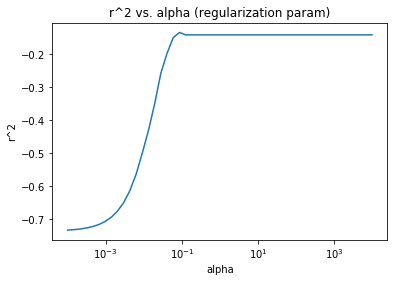

best_score          -0.135106
alpha               0.0868511
best_score_ratio     0.948531
Name: TY, dtype: object


AM_dv01         -0.0
LevFunds_dv01    0.0
7y               0.0
7y_lag5          0.0
Name: beta, dtype: float64

In [44]:
# Now we do the same thing, with the target variable some forward period of swap rate changes
ct = 'TY'
window = 5
fwd_per = 20
unadj_feat = ['AM', 'LevFunds']
model = Lasso()
swap = CT_SWAP_MAP[ct][0]
target = swap+'_fwd'+str(fwd_per)
num_features = np.hstack([[a+feat_adj for a in unadj_feat], swap, swap+'_lag'+str(window)])
r = get_rolling_cts(adj_ct_dfs, feat_adj, window=window, swap_chg_lags=[1,2], 
                    swap_chg_fwds=[1,5,20,60], resample_per='W-FRI')
search, output_df = run_cv(r[ct].dropna(how='any'), ct, feat_adj, is_start_dt, num_features, target, 
                           tss_splits=5, model=model, model_type='Regression', hyperparam_name='alpha',
                            scorer=None, sample_weight=None, max_train_size=208)
print(r'TY {0}wk changes vs {1}d fwd swap changes'.format(window, fwd_per))
display_cv_metrics(search, 'alpha', 'r^2', log_scale=True)
print(output_df[['best_score', 'alpha', 'best_score_ratio']])
pd.Series(output_df['beta'], name='beta', index=num_features)

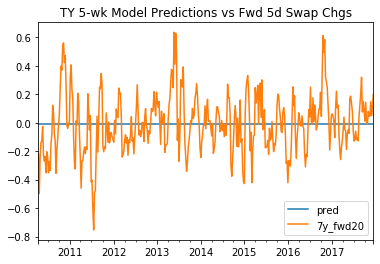

In [45]:
# Predictions again
ty_data = r[ct].dropna(how='any')
X = ty_data.loc[:, num_features]
y = ty_data.loc[:, target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)
pred = pd.Series(search.predict(X_train), index=X_train.index).rename('pred')
fig, ax = plt.subplots()
pred.plot()
y_train.plot()
ax.legend()
ax.set_title('TY 5-wk Model Predictions vs Fwd 5d Swap Chgs')
plt.show()

# Extreme values
- Not much from classification either, try filtering for extreme values
- Look at average changes over subsequent periods from various lookbacks

## Outright

In [46]:
from eptest_main import gen_subseq_returns, analyze_sub_rets, plot_subsq_rets

In [47]:
# crossvalidation to evaluate if theres anything here outright

# some parameters
is_start_dt = dt.date(2010, 1, 1)
feat_adj = '_dv01'
unadj_feat = ['LevFunds']
filter_feat = 'LevFunds_dv01'
z_thresh = 1.0
clf_params = {'model__class_weight': 'balanced', 'model__solver': 'lbfgs'}

subsq_len = 22
window = 13

outputs = {}
#data
# resample on Friday's with 'window' sized rolling weekly differences
r = get_rolling_cts(adj_ct_dfs, feat_adj, window=window, swap_chg_lags=[1], swap_chg_fwds=[1])

normed_pos = get_norm_cts(r, swaps, 26, swap_chg_fwds=[1, 5, 10, 22, 44])
for ct in CT_SWAP_MAP.keys():
    extr_corr_pos = normed_pos[ct]
    extr_corr_pos = extr_corr_pos[abs(extr_corr_pos[filter_feat])>z_thresh]


    swap = CT_SWAP_MAP[ct][0]
    target = swap+'_fwd'+str(subsq_len)+'_sign'
    target_unadj = swap+'_fwd'+str(subsq_len)
    target_lag = swap#+'_lag'+str(window)
    num_features = np.hstack([[a+feat_adj for a in unadj_feat], target_lag])
    sample_weight = swap+'_fwd'+str(subsq_len)+'_abs'

    output_df = run_cv_weighted(extr_corr_pos, ct, feat_adj, is_start_dt, num_features, target, sample_weight=sample_weight, 
                                tss_splits=5, model=LogisticRegression(class_weight='balanced', solver='lbfgs'), 
                                hyperparam_name='C', max_train_size=208, clf_params=clf_params)
    outputs[ct] = output_df
res = pd.concat(outputs, axis=1)
res.loc['beta'] = res.loc['beta'].apply(lambda x: x.round(5))
res

C:\Users\Brendan\FinML\MLFin\ExPtTest\eptest_main.py:208: RuntimeWarning: invalid value encountered in sign
  new_df[fwdname + '_sign'] = np.sign(new_df[fwdname])
C:\Users\Brendan\FinML\MLFin\ExPtTest\eptest_main.py:232: RuntimeWarning: invalid value encountered in sign
  ct_df[fwdname+'_sign'] = np.sign(ct_df[fwdname])


,FV,TU,TY,US,WN
beta,"[[-0.01121, -7e-05]]","[[0.31264, -0.03243]]","[[-0.04376, 0.03671]]","[[-0.13728, 0.51074]]","[[-0.12599, 0.01361]]"
best_score,0.48824,0.524864,0.489247,0.603659,0.525836
C,0.00910298,0.828643,0.0596362,3.72759,0.126486
best_score_ratio,0.960472,0.885313,0.978494,1.50915,1.26403


C:\Users\Brendan\FinML\MLFin\ExPtTest\eptest_main.py:208: RuntimeWarning: invalid value encountered in sign
  new_df[fwdname + '_sign'] = np.sign(new_df[fwdname])
C:\Users\Brendan\FinML\MLFin\ExPtTest\eptest_main.py:232: RuntimeWarning: invalid value encountered in sign
  ct_df[fwdname+'_sign'] = np.sign(ct_df[fwdname])


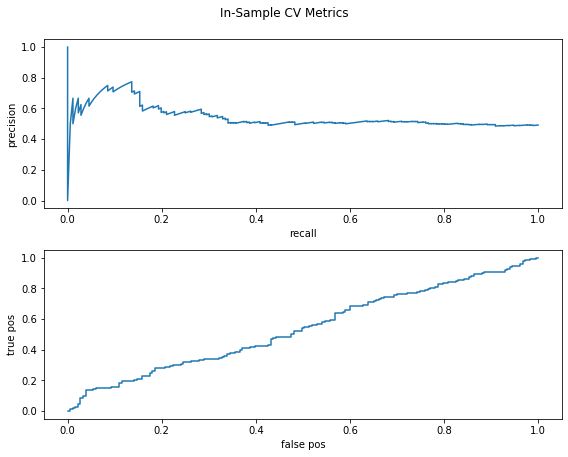

        Pred_0  Pred_1
True_0      96      87
True_1      90      86


In [48]:
# Precision/recall and TP/FP curves
# Confusion matrix
# More or fewer features doesn't matter basically a coin flip
ct = 'US'
r = get_rolling_cts(adj_ct_dfs, feat_adj, window=window, swap_chg_lags=[1], swap_chg_fwds=[1])
normed_pos = get_norm_cts(r, swaps, 26, swap_chg_fwds=[1, 5, 10, 22, 44])
us_data = normed_pos[ct].dropna(how='any')
swap = CT_SWAP_MAP[ct][0]
unadj_feat = ['AM', 'Dealers', 'LevFunds', 'NonCom']
target_unadj = swap+'_fwd'+str(subsq_len)
target = target_unadj+'_sign'
target_lag = swap#+'_lag'+str(window)
num_features = np.hstack([[a+feat_adj for a in unadj_feat], target_lag])
X = us_data.loc[:, num_features]
y = us_data.loc[:, target]
model = LogisticRegression(class_weight='balanced', solver='lbfgs')
search, output_df = run_cv(us_data, ct, feat_adj, is_start_dt, num_features, target, 
                           tss_splits=5, model=model, model_type='Classification', hyperparam_name='C',
                            scorer=None, sample_weight=None, max_train_size=208)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)
display_is_metrics(search, X_train, y_train)

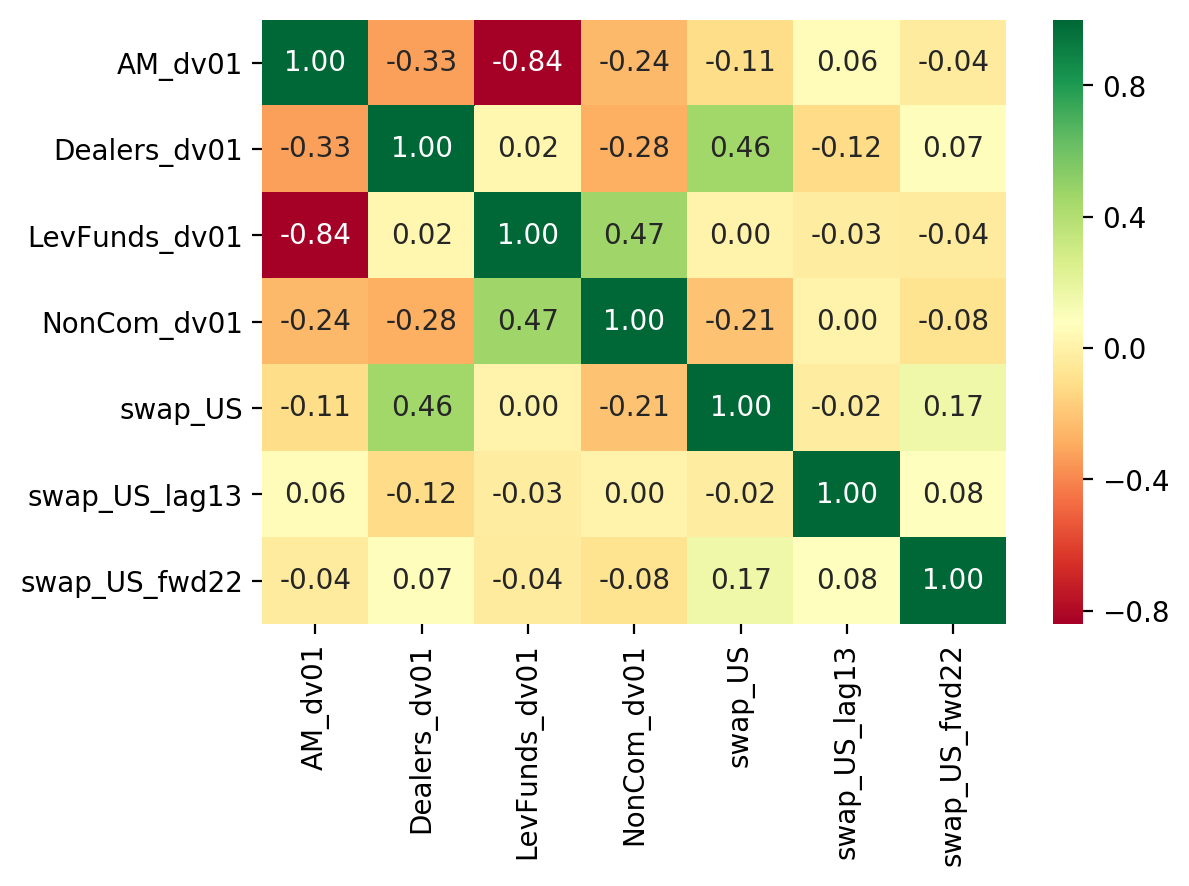

array([[-0.04375653,  0.03671373]])

In [49]:
# correlations filtered by extreme values
ct = 'US'
extr_corr_pos = normed_pos[ct]
extr_corr_pos = extr_corr_pos[abs(extr_corr_pos[filter_feat])>z_thresh]
swap = CT_SWAP_MAP[ct][0]
target_unadj = swap+'_fwd'+str(subsq_len)
target_lag = swap#+'_lag'+str(window)
target_lag2 = swap+'_lag'+str(window)
num_features = np.hstack([[a+feat_adj for a in unadj_feat], target_lag, target_lag2])
fig, ax = plt.subplots(figsize=(6,4), dpi=200)
sns.heatmap(extr_corr_pos.loc[:, np.hstack([num_features, target_unadj])].corr(), annot=True, fmt='.2f', cmap='RdYlGn', ax=ax)
plt.show()
outputs['TY'].loc['beta']

### Beta timeseries

In [50]:
# look at the timeseries of betas under rolling model fits to see if there's consistency
sample_weight = swap+'_fwd'+str(subsq_len)+'_abs'
extr_corr_pos[target] = np.sign(extr_corr_pos[target_unadj])
extr_corr_pos[sample_weight] = np.abs(extr_corr_pos[target_unadj])
features = ['LevFunds_dv01', CT_SWAP_MAP[ct][0]]
datas = extr_corr_pos.loc[:, np.hstack([features, target, sample_weight])].dropna(how='any')

tss = TimeSeriesSplit(n_splits=5, max_train_size=204)
model = LogisticRegression(class_weight='balanced', solver='lbfgs')
betas = []
dates = []
is_end_dt = dt.date(2018,1,1)
for train_idx, test_idx in tss.split(datas.loc[:is_end_dt]):
    X_train = datas.iloc[train_idx].loc[:, features]
    y_train = datas.iloc[train_idx].loc[:, target]
    w_train = datas.iloc[train_idx].loc[:, sample_weight]
    model.fit(X_train, y_train, sample_weight=w_train)
    betas.append(model.coef_.squeeze())
    dates.append(extr_corr_pos.index[train_idx[-1]])
pd.DataFrame(betas, index=dates, columns=features)

C:\Users\Brendan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sign
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Brendan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Brendan\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.

,LevFunds_dv01,swap_US
2012-03-16,0.573146,-0.177329
2013-05-24,0.280014,-0.034414
2014-08-22,-0.096083,0.329840
2016-03-11,0.062586,0.123189
2017-01-13,-0.060063,0.341244


### Avg Subsequent Swap Change Plots

C:\Users\Brendan\FinML\MLFin\ExPtTest\eptest_main.py:208: RuntimeWarning: invalid value encountered in sign
  new_df[fwdname + '_sign'] = np.sign(new_df[fwdname])
C:\Users\Brendan\FinML\MLFin\ExPtTest\eptest_main.py:232: RuntimeWarning: invalid value encountered in sign
  ct_df[fwdname+'_sign'] = np.sign(ct_df[fwdname])
C:\Users\Brendan\FinML\MLFin\ExPtTest\eptest_main.py:345: RuntimeWarning: divide by zero encountered in true_divide
  ann_ir = avg_sub_rets.divide(std_sub_rets)*np.sqrt(250/sub_rets.columns.values)
C:\Users\Brendan\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


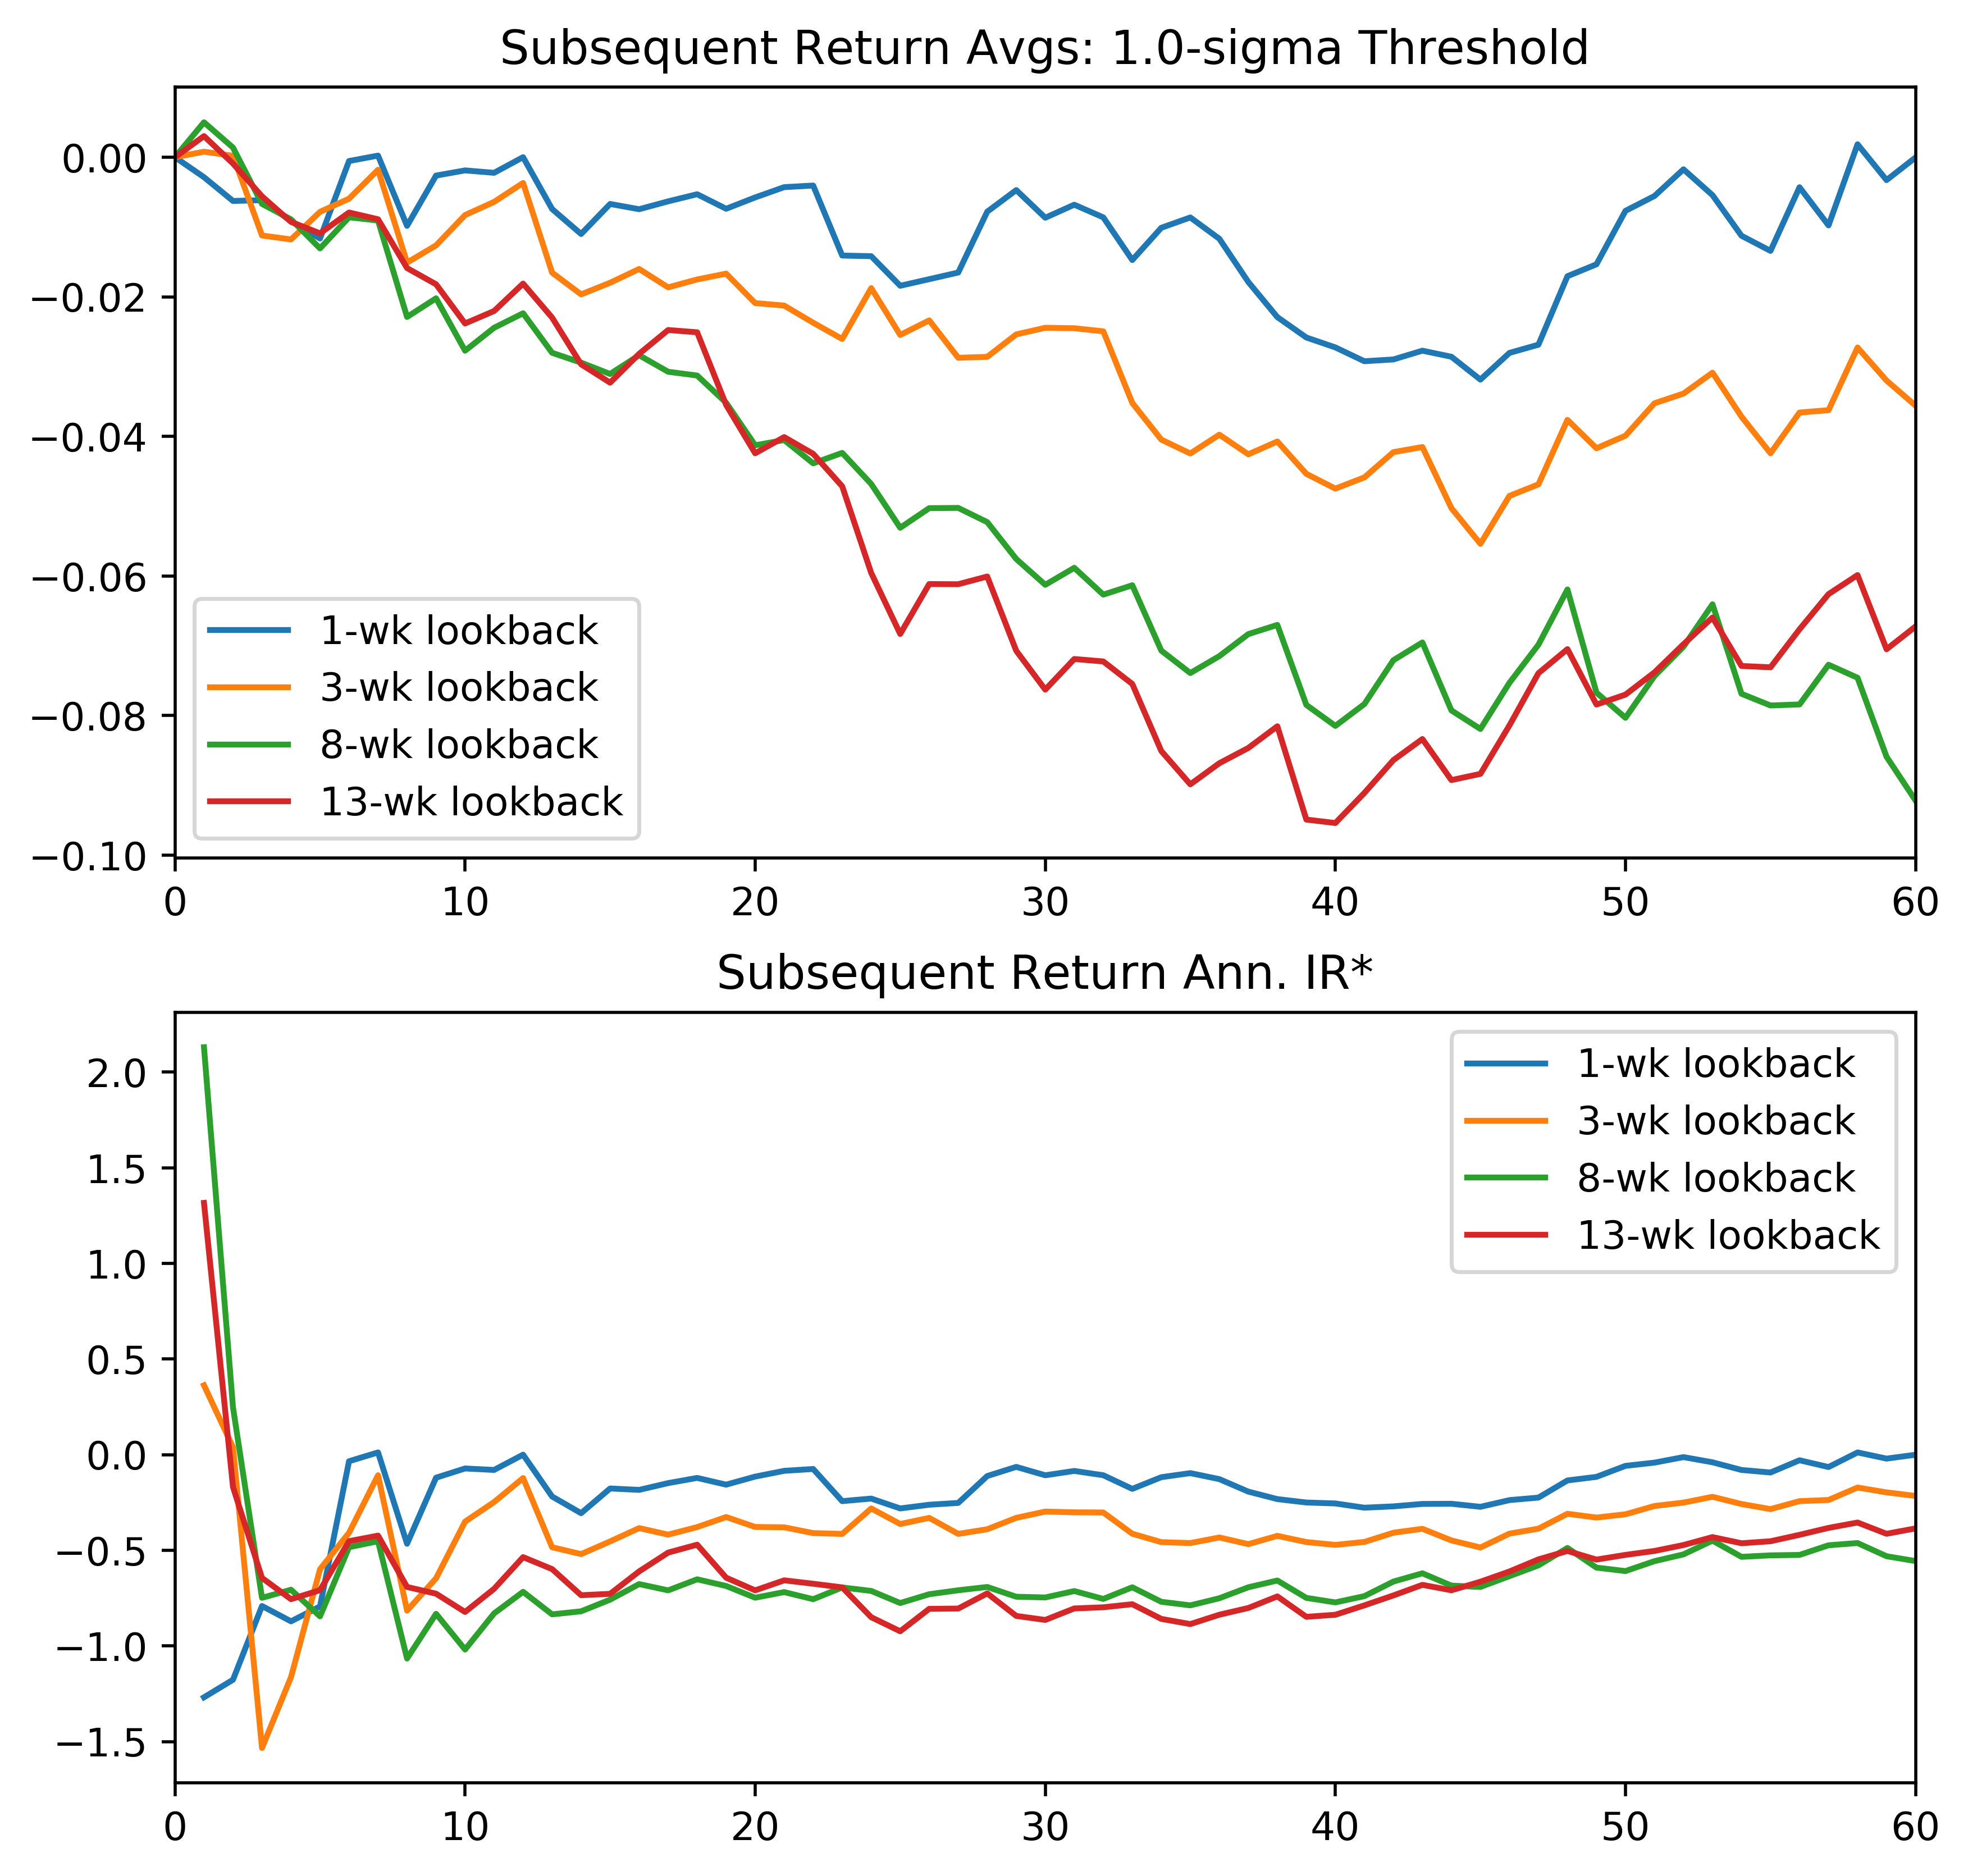

lookback          1                            3                           8   \
fwd period        5         20        60       5        20       60        5    
Mean         -0.0116   -0.0058   -0.0000  -0.0078  -0.0209  -0.0356   -0.0131   
Std Dev       0.1038    0.1779    0.3329   0.0924   0.1956   0.3372    0.1093   
Ann. IR      -0.7933   -0.1145   -0.0002  -0.5988  -0.3779  -0.2155   -0.8452   
Min          -0.2890   -0.5847   -0.9923  -0.1938  -0.5847  -0.9923   -0.3950   
Max           0.3120    0.3795    0.8069   0.3120   0.4545   0.6615    0.2468   
Max DD       -0.2890   -0.5847   -0.9923  -0.2098  -0.5847  -1.0571   -0.3950   
Num Obs     108.0000  108.0000  108.0000  91.0000  91.0000  91.0000  108.0000   
Hit Ratio     0.4444    0.4722    0.5370   0.4615   0.4945   0.5055    0.4444   

lookback                              13                      
fwd period        20        60        5         20        60  
Mean         -0.0413   -0.0922   -0.0109   -0.0424   -0.0672  
Std Dev       0.1952    0.3383    0.1089    0.2115    0.3562  
Ann. IR      -0.7477   -0.5562   -0.7082   -0.7092   -0.3853  
Min          -0.5847   -0.9923   -0.3950   -0.5847   -0.9923  
Max           0.4655    0.7620    0.2403    0.4655    0.8069  
Max DD       -0.6340   -1.0072   -0.3950   -0.6340   -1.0072  
Num Obs     108.0000  108.0000  111.0000  111.0000  111.0000  
Hit Ratio     0.4630    0.3889    0.4775    0.3874    0.4144

In [51]:
is_start_dt = dt.date(2010, 1, 1)
is_end_dt = dt.date(2018,1,1)
end_data_dt = swaps.index[-1]
feat_adj = '_dv01'

filter_feat = 'LevFunds_dv01'
z_thresh = 1.0
windows = [1, 3, 8, 13]
ct = 'US'

swap = CT_SWAP_MAP[ct][0]
plot_subsq_rets(adj_ct_dfs, ct, feat_adj, filter_feat, windows, swaps=swaps, z_threshold=z_thresh, is_start_dt=is_start_dt,
                is_end_dt=is_end_dt, zscore_lookback=52, max_len=60)


### Decision boundary for learning model, what if we try a support vector classifier

Best reg param C: 0.8286427728546842
Best score: 0.5429


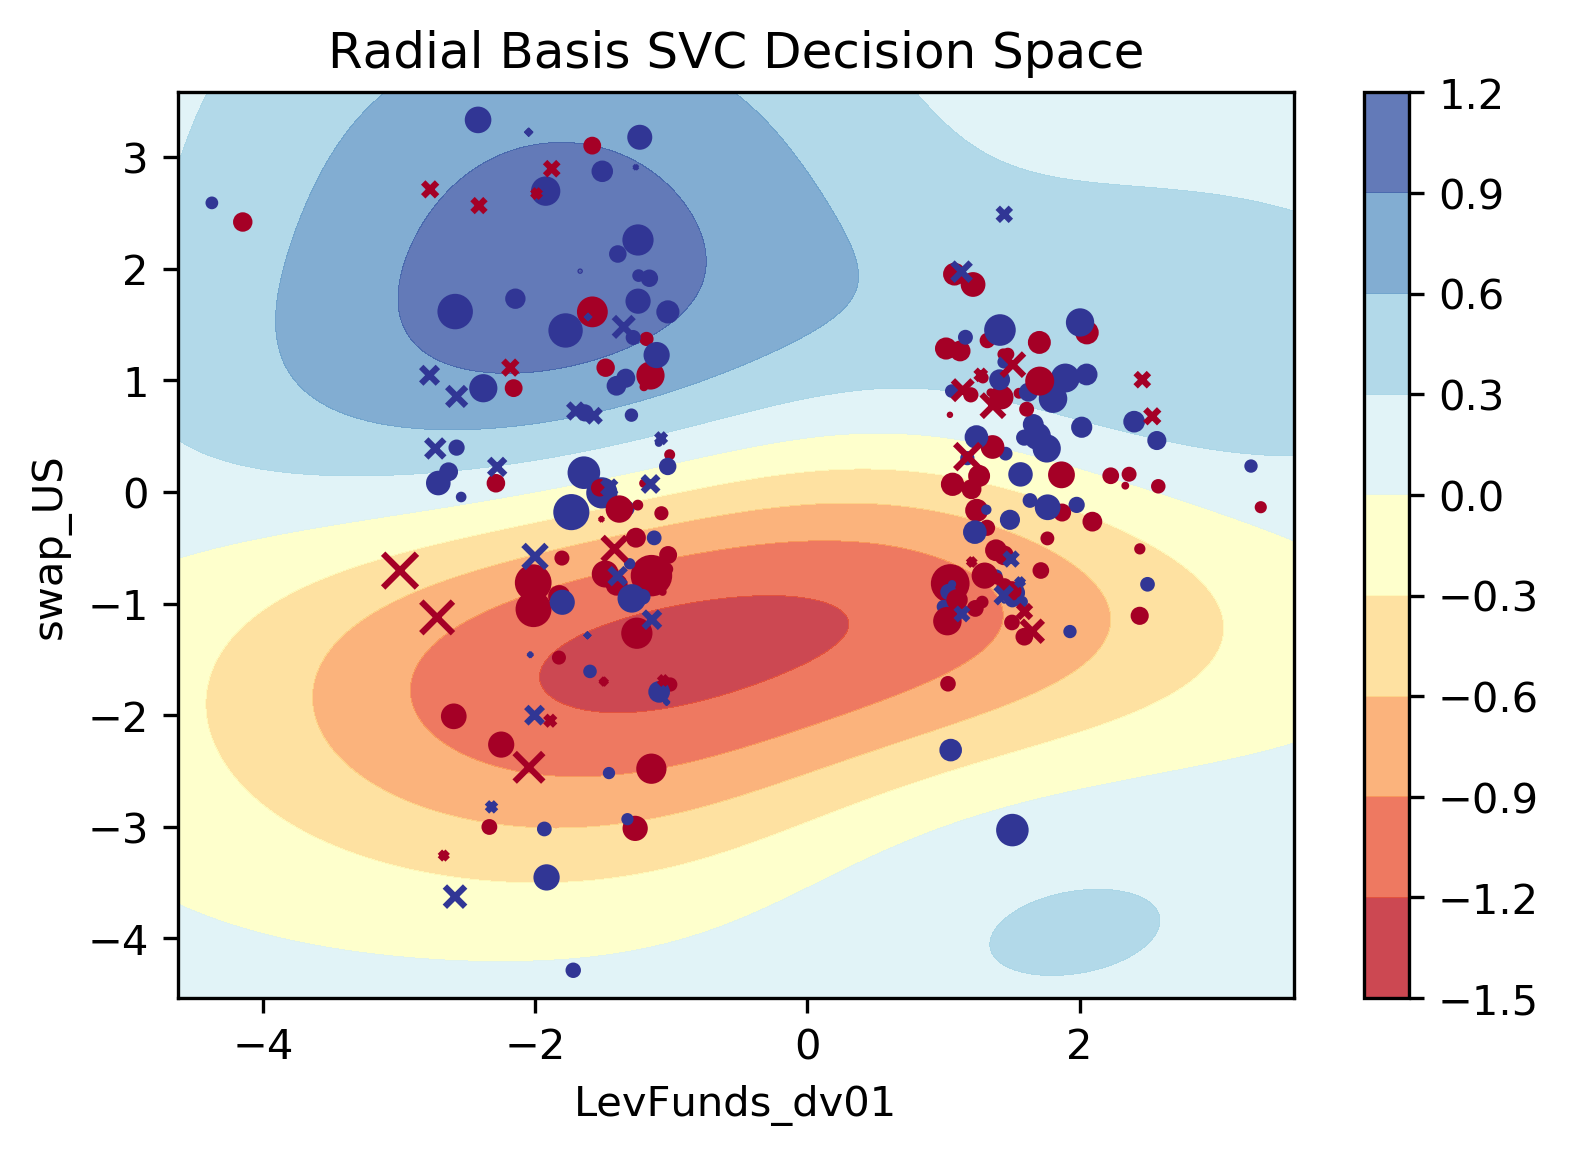

In [55]:
feat1, feat2 = features[0], features[1]

X1 = extr_corr_pos[np.hstack([features, sample_weight])].copy(deep=True)
y1 = extr_corr_pos[target].copy(deep=True)

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.25, shuffle=False)
X_train2 = X_train1[features]
w_train2 = X_train1[sample_weight]
w_test1 = X_test1[sample_weight]

# plotting vars
x_min, x_max = X1[feat1].min()-0.25, X1[feat1].max()+0.25
y_min, y_max = X1[feat2].min()-0.25, X1[feat2].max()+0.25
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
feat_mesh = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=[feat1, feat2])

# Create Preprocessor
num_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scale', StandardScaler(with_mean=True))
])

# Create and fit model
model = SVC(kernel='rbf', gamma='auto', class_weight='balanced')
#model = LogisticRegression(multi_class='auto', class_weight='balanced', solver='lbfgs')
pipe = Pipeline(steps=[
        ('preprocessor', num_transformer),
        ('model', model)
])
# get best regularization param from cross validation
tss = TimeSeriesSplit(n_splits=5, max_train_size=208)
param_space = np.logspace(-4, 4, 50)
search = GridSearchCV(pipe, {'model__C': param_space}, n_jobs=-1, cv=tss)
search.fit(X_train2, y_train1, model__sample_weight=w_train2)

if isinstance(pipe.named_steps['model'], SVC):
    Z = search.decision_function(feat_mesh)
else:
    Z = search.predict_proba(feat_mesh).T[1]
Z = Z.reshape(xx.shape)

fig, ax = plt.subplots(dpi=300)
contours = ax.contourf(xx, yy, Z, cmap='RdYlBu', alpha=0.8)
plt.colorbar(contours)
ax.scatter(X_train2[feat1], X_train2[feat2], c=y_train1, s=w_train2*100, cmap='RdYlBu')
ax.scatter(X_test1[feat1], X_test1[feat2], c=y_test1, s=w_test1*100, cmap='RdYlBu', marker='x')

ax.set_xlabel(feat1)
ax.set_ylabel(feat2)
ax.set_title('Radial Basis SVC Decision Space')
print(r'Best reg param C: {0}'.format(search.best_params_['model__C']))
print(r'Best score: {0}'.format(np.round(search.best_score_, 4)))
plt.show()


## Curves

In [19]:
# Same deal with curves
from itertools import combinations
curves = ([c for c in combinations(CT_SIZES.keys(), 2)])

swap_chg_fwds = [1, 5, 10, 20, 60]
window = 8
r = get_rolling_cts(adj_ct_dfs, feat_adj, window=window)
curve_diffs = get_norm_curve_diffs(curves, r, window, swaps, swap_chg_fwds=swap_chg_fwds)
daily_curves = get_daily_curve_diffs(curves, r, swaps)
daily_curves.head()


C:\Users\Brendan\FinML\MLFin\ExPtTest\eptest_main.py:208: RuntimeWarning: invalid value encountered in sign
  new_df[fwdname + '_sign'] = np.sign(new_df[fwdname])
C:\Users\Brendan\FinML\MLFin\ExPtTest\eptest_main.py:292: RuntimeWarning: invalid value encountered in sign
  curve_diff[fwdname + '_sign'] = np.sign(curve_diff[fwdname])


,25y-2y,25y-5y,25y-7y,25y-swap_US,5y-2y,7y-2y,7y-5y,swap_US-2y,swap_US-5y,swap_US-7y
2010-01-01,3.07415,1.51745,0.95735,0.14005,1.5567,2.1168,0.5601,2.9341,1.3774,0.8173
2010-01-04,3.13155,1.55345,0.99645,0.13935,1.5781,2.1351,0.5570,2.9922,1.4141,0.8571
2010-01-05,3.12650,1.57530,1.02580,0.15880,1.5512,2.1007,0.5495,2.9677,1.4165,0.8670
2010-01-06,3.22505,1.61325,1.04455,0.16355,1.6118,2.1805,0.5687,3.0615,1.4497,0.8810
2010-01-07,3.21575,1.60295,1.04125,0.16575,1.6128,2.1745,0.5617,3.0500,1.4372,0.8755


C:\Users\Brendan\FinML\MLFin\ExPtTest\eptest_main.py:345: RuntimeWarning: divide by zero encountered in true_divide
  ann_ir = avg_sub_rets.divide(std_sub_rets)*np.sqrt(250/sub_rets.columns.values)
C:\Users\Brendan\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


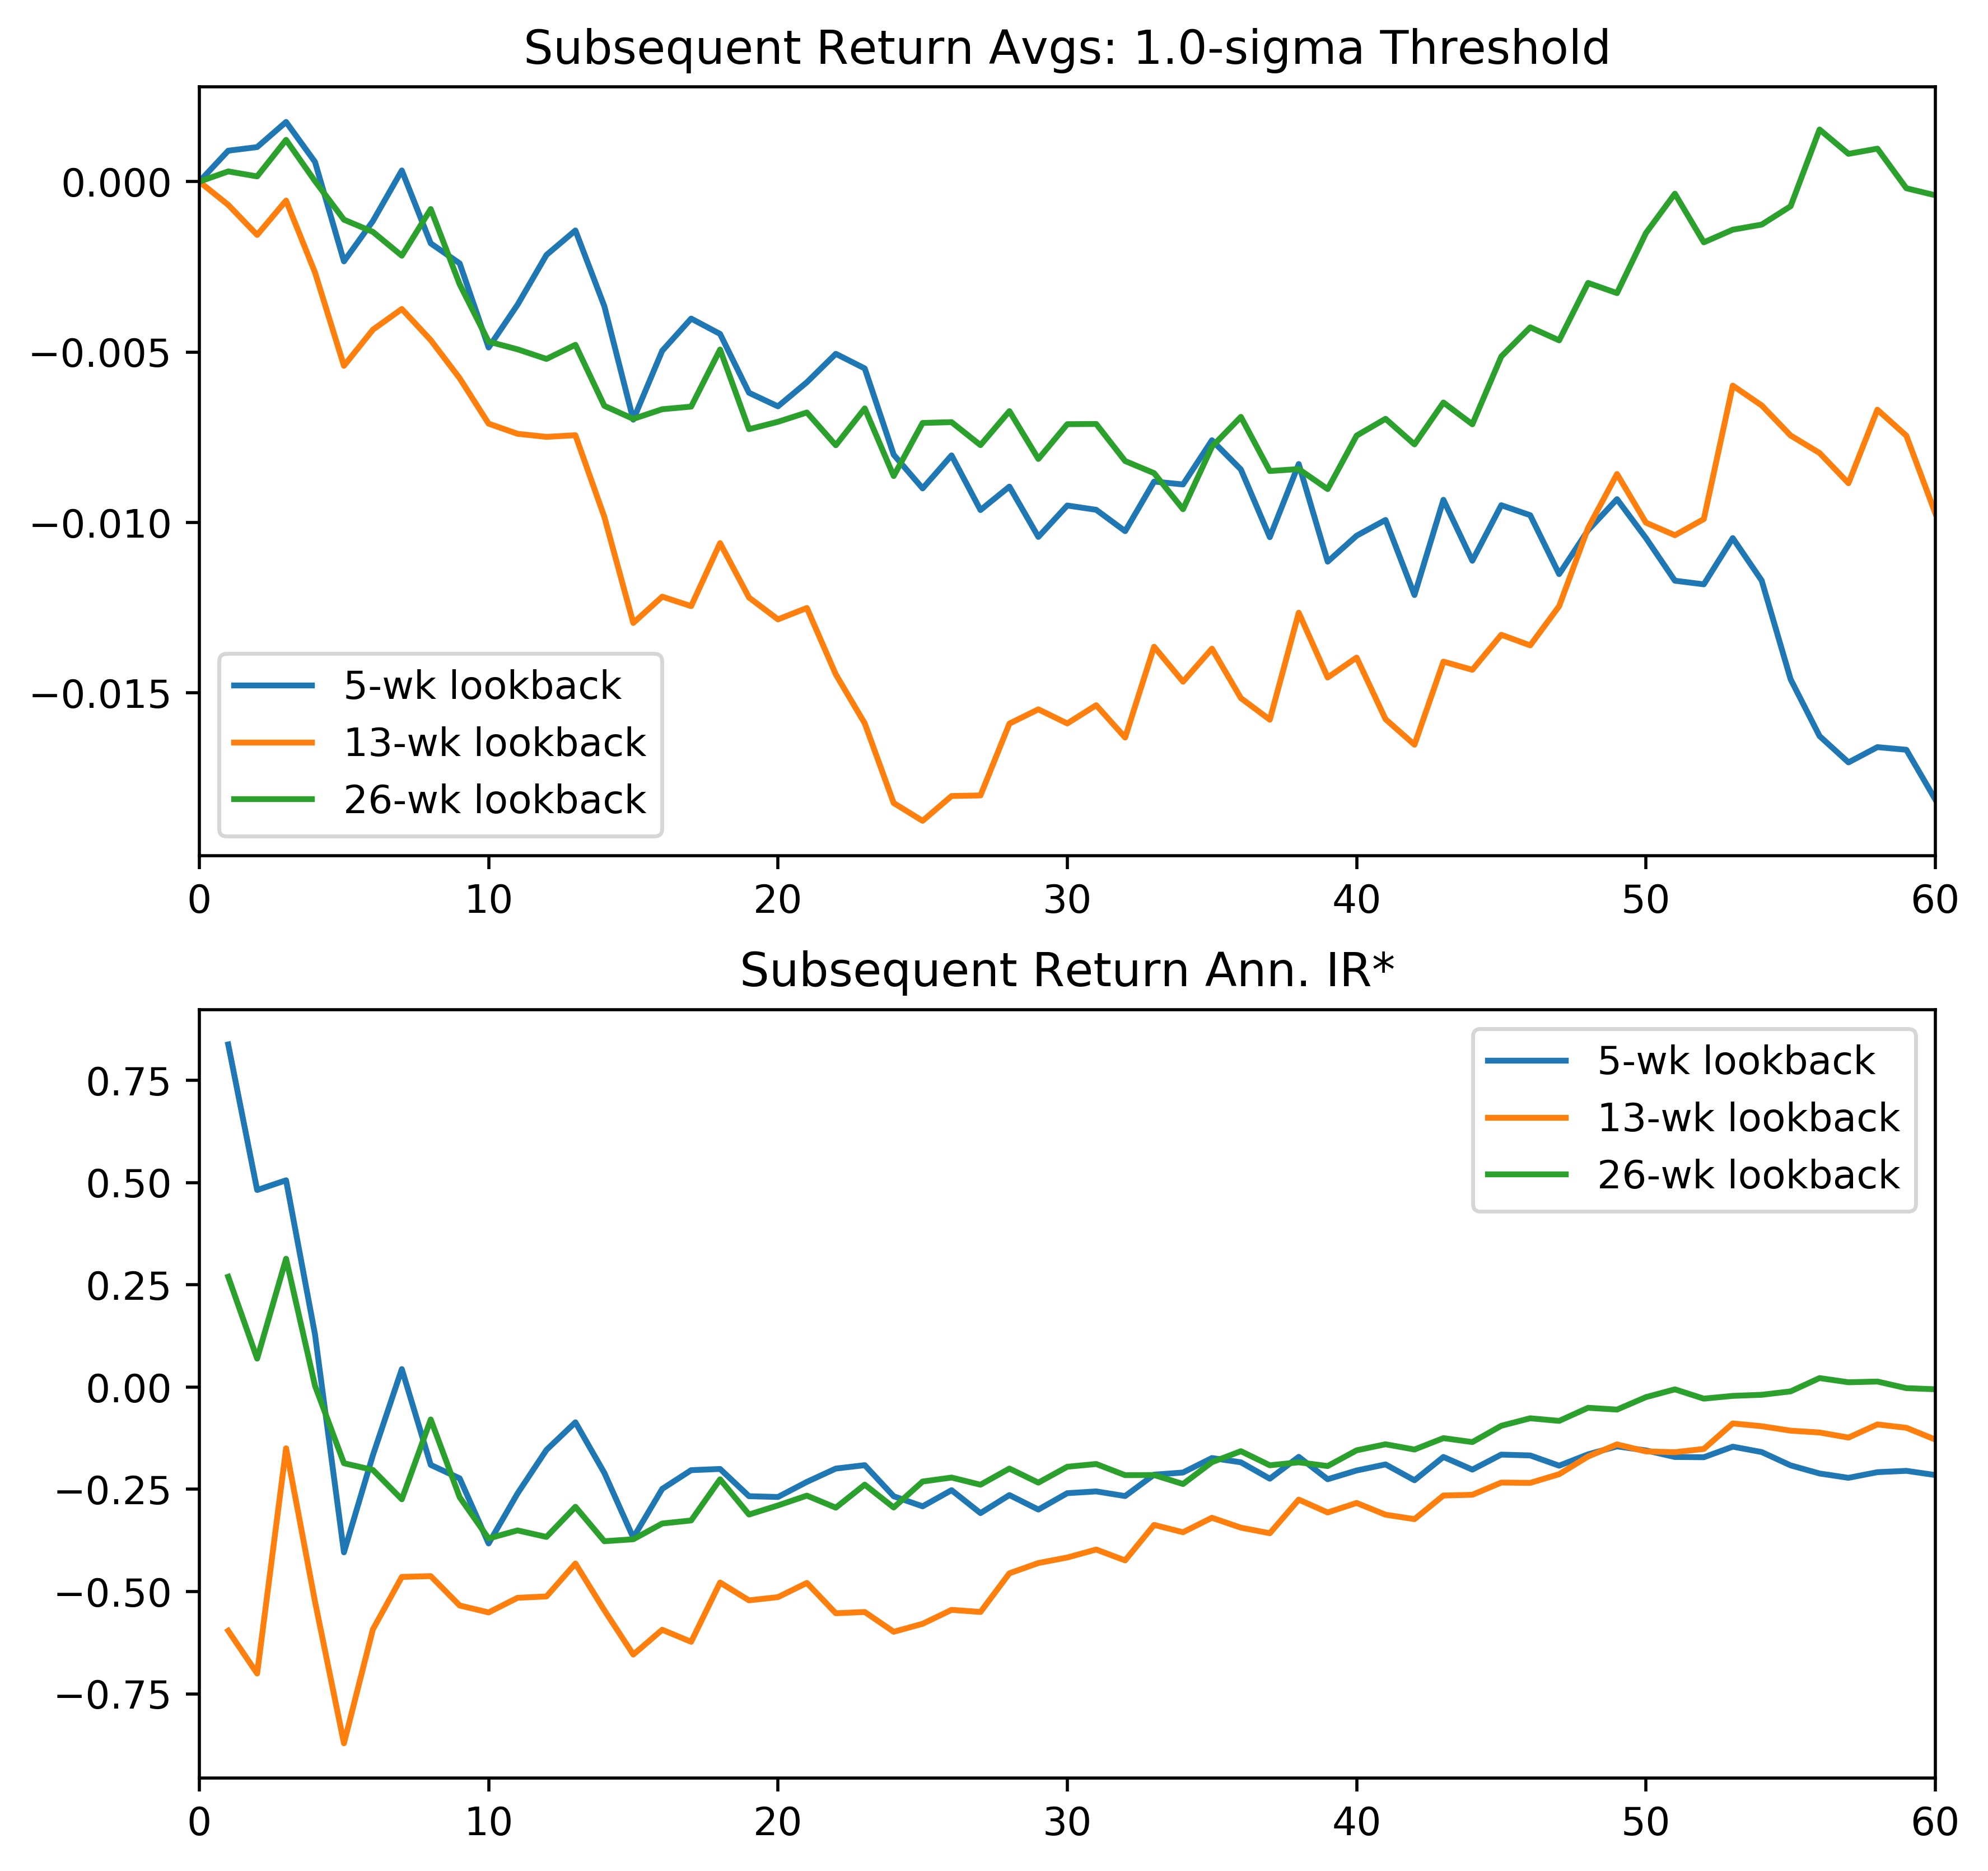

lookback          5                             13                      \
fwd period        5         20        60        5         20        60   
Mean         -0.0023   -0.0066   -0.0181   -0.0054   -0.0128   -0.0097   
Std Dev       0.0409    0.0867    0.1720    0.0439    0.0884    0.1548   
Ann. IR      -0.4041   -0.2688   -0.2151   -0.8711   -0.5137   -0.1283   
Min          -0.1918   -0.3425   -0.3955   -0.1918   -0.2575   -0.3590   
Max           0.0957    0.2000    0.3715    0.0957    0.1819    0.3465   
Max DD       -0.1938   -0.3425   -0.3955   -0.1938   -0.2818   -0.4074   
Num Obs     147.0000  147.0000  147.0000  157.0000  157.0000  157.0000   
Hit Ratio     0.4354    0.4898    0.4422    0.4395    0.4777    0.4522   

lookback          26                      
fwd period        5         20        60  
Mean         -0.0011   -0.0070   -0.0004  
Std Dev       0.0424    0.0861    0.1508  
Ann. IR      -0.1862   -0.2895   -0.0054  
Min          -0.1165   -0.2319   -0.3480  
Max           0.1095    0.2575    0.3780  
Max DD       -0.1165   -0.2319   -0.3560  
Num Obs     209.0000  209.0000  209.0000  
Hit Ratio     0.4785    0.4402    0.4545

In [20]:
# resample on Friday's with 'window' sized rolling weekly differences
is_start_dt = dt.date(2010, 1, 1)
is_end_dt = dt.date(2018,1,1)
end_data_dt = swaps.index[-1]
feat_adj = '_dv01'

filter_feat = 'LevFunds_dv01'
z_thresh = 1.0
windows = [5, 13, 26]
curve = 'US-FV'

curve_swap_name = curve.split("-")
curve_swap = '-'.join([CT_SWAP_MAP[curve_swap_name[0]][0], CT_SWAP_MAP[curve_swap_name[1]][0]])
curve_swap
plot_subsq_rets(adj_ct_dfs, curve, feat_adj, filter_feat, windows, swaps=swaps, z_threshold=z_thresh, is_start_dt=is_start_dt,
                is_end_dt=is_end_dt, swap_name=curve_swap, zscore_lookback=52, max_len=60, curve=True, daily_curves=daily_curves)

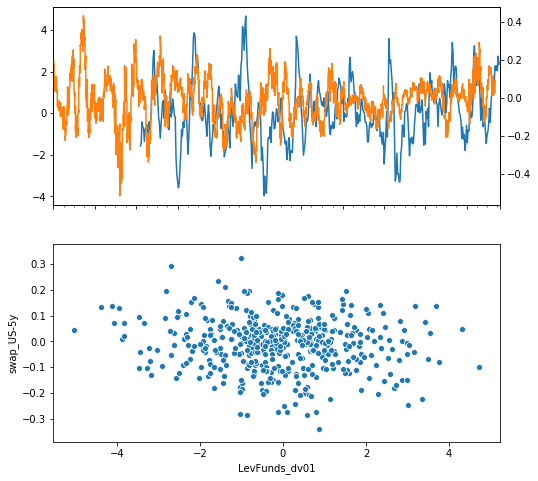

In [21]:
fig, ax = plt.subplots(figsize=(8,8), nrows=2)
curve_diffs['US-FV'].loc[:, 'AM_dv01'].plot(ax=ax[0])
daily_curves['swap_US-5y'].diff(30).shift(-30).plot(ax=ax[0], secondary_y=True)
sns.scatterplot(x=curve_diffs['US-FV'].loc[:, 'LevFunds_dv01'], y=daily_curves['swap_US-5y'].diff(30).shift(-30), ax=ax[1])
plt.show()

# Findings to explore

## Classification
- Outright US maybe ok
    - 'AM', 'LevFunds', concurrent swap
    - z_filtered on AM
    - logistic, accuracy scored
    - rolling 13wk features and 20d predictions
- curve stuff might exist, look at US vs FV 
    - 'LevFunds', concurrent swap as features
    - z_filtered on LevFunds
    - logistic regression
    - accuracy scoring
    - rolling 8wk features and 20d predictions
    


## Backtest

### Outright US


In [22]:
# parameters
pos_agg_window = 13 #weeks
trade_len = 40 #days
pt_sl = (3,0.25)
norm_window = 26 #weeks
start_dt = dt.date(2010,1,1)
end_dt = dt.date(2018,1,1)
feat_adj = '_dv01'
filter_feat = 'LevFunds_dv01'
z_thresh_positions = 1.0
z_thresh_swap = 0.1
ct = 'US'
swap = CT_SWAP_MAP[ct][0]


# get data
r = get_rolling_cts(adj_ct_dfs, feat_adj, window=pos_agg_window, swap_chg_lags=[1], swap_chg_fwds=[1])
normed_pos = get_norm_cts(r, swaps, norm_window, swap_chg_fwds=[1])


signal_data = normed_pos[ct].loc[start_dt:end_dt]
    
signal_data[swap] = signal_data[swap].subtract(signal_data[swap].rolling(norm_window).mean()).\
                                divide(signal_data[swap].rolling(norm_window).std())
swap_data = swaps.loc[start_dt:end_dt, swap]
# Build the returns from approximate equity in 10 years of the swap rate
# Need this return series to take advantage of the code I had previously built
swap_data_10yr_risk = (1. + swap_data.diff(1).fillna(0) / 10.).cumprod()

# build signals
signals_feat = zscore_signal(signal_data[filter_feat], z_thresh_positions, signal_type='Reversion')
signals_trailingcurve = zscore_signal(signal_data[swap], z_thresh_swap, signal_type='Momentum')
signals = signals_trailingcurve.to_frame().join(signals_feat)
signals['composed'] = signals.apply(lambda x: 0 if np.sign(x[filter_feat])!=np.sign(x[swap]) else x[filter_feat], axis=1)
signals['composed'].value_counts()

C:\Users\Brendan\FinML\MLFin\ExPtTest\eptest_main.py:232: RuntimeWarning: invalid value encountered in sign
  ct_df[fwdname+'_sign'] = np.sign(ct_df[fwdname])
C:\Users\Brendan\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Brendan\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in sign


 0.0    246
 1.0     41
-1.0     29
Name: composed, dtype: int64

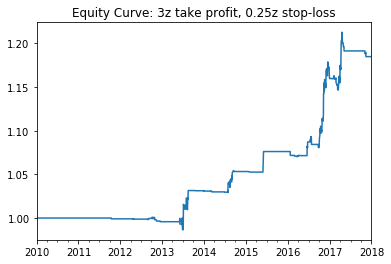

In [23]:
events0, df0 = zscore_sizing(signals['composed'], swap_data, vertbar=trade_len, pt_sl=pt_sl, even_weight=True)
events = generate_pnl(events0, swap_data_10yr_risk, pct_change=True)
mtm_pnl = generate_mtm_pnl(events, swap_data_10yr_risk, log_diff=True)
pnl_index = generate_pnl_index(mtm_pnl, None)
fig, ax = plt.subplots()
pnl_index.plot(ax=ax)
ax.set_title('Equity Curve: 3z take profit, 0.25z stop-loss')
plt.show()

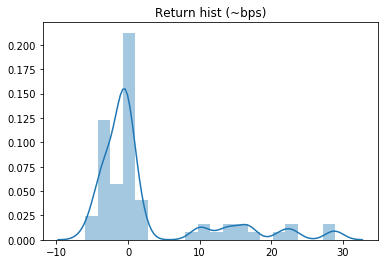

In [24]:
# Distribution of each trades pnl (not weighted by uniqueness, )
fig, ax = plt.subplots()
sns.distplot(events.ret*events.trgt*1000, ax=ax)
ax.set_title('Return hist (~bps)')
plt.show()

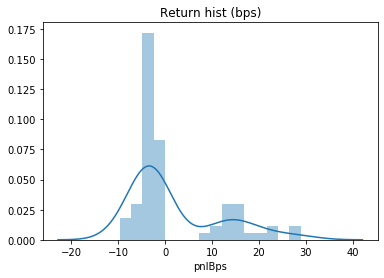

In [25]:
# dummy check
eventsCheck = events.merge(swaps[swap].rename('exit'), left_on='t1', right_index=True)
eventsCheck['entry'] = swaps[swap]
eventsCheck['pnlBps'] = (eventsCheck['exit'] - eventsCheck['entry']) * eventsCheck['side']*100
eventsCheck['TradeDays'] = (eventsCheck['t1']-eventsCheck.index)
fig, ax = plt.subplots()
sns.distplot(eventsCheck['pnlBps'], ax=ax, bins=16)
ax.set_title('Return hist (bps)')
plt.show()

In [26]:
# Performance summary stats
generate_perf_summary(events, swap_data_10yr_risk)

C:\Users\Brendan\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


Ann. Ret.                       0.0282773
Ann. Vol.                       0.0263809
Ann. Vol. (m)                   0.0294553
Sharpe                            1.07188
Sharpe (m)                       0.960005
Calmar                             1.0387
Max Drawdown                   -0.0272236
# Trades                               70
Avg. PnL                         0.120928
Long%Signals                     0.585714
Hit Ratio                        0.271429
Avg. Trade Days    6 days 10:17:08.571428
First Entry           2011-10-14 00:00:00
Last Exit             2017-11-14 00:00:00
dtype: object

<function matplotlib.pyplot.show(*args, **kw)>

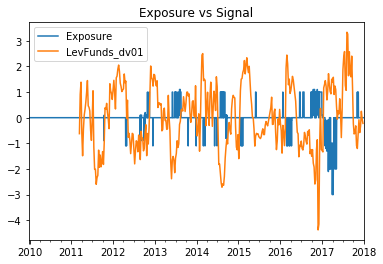

In [27]:
# Positions
exposures = generate_exposures(events, swap_data_10yr_risk)
fig, ax = plt.subplots()
exposures.rename('Exposure').plot(ax=ax)
signal_data[filter_feat].plot(ax=ax)
ax.set_title('Exposure vs Signal')
ax.legend()
plt.show

C:\Users\Brendan\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in sign
C:\Users\Brendan\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\Brendan\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


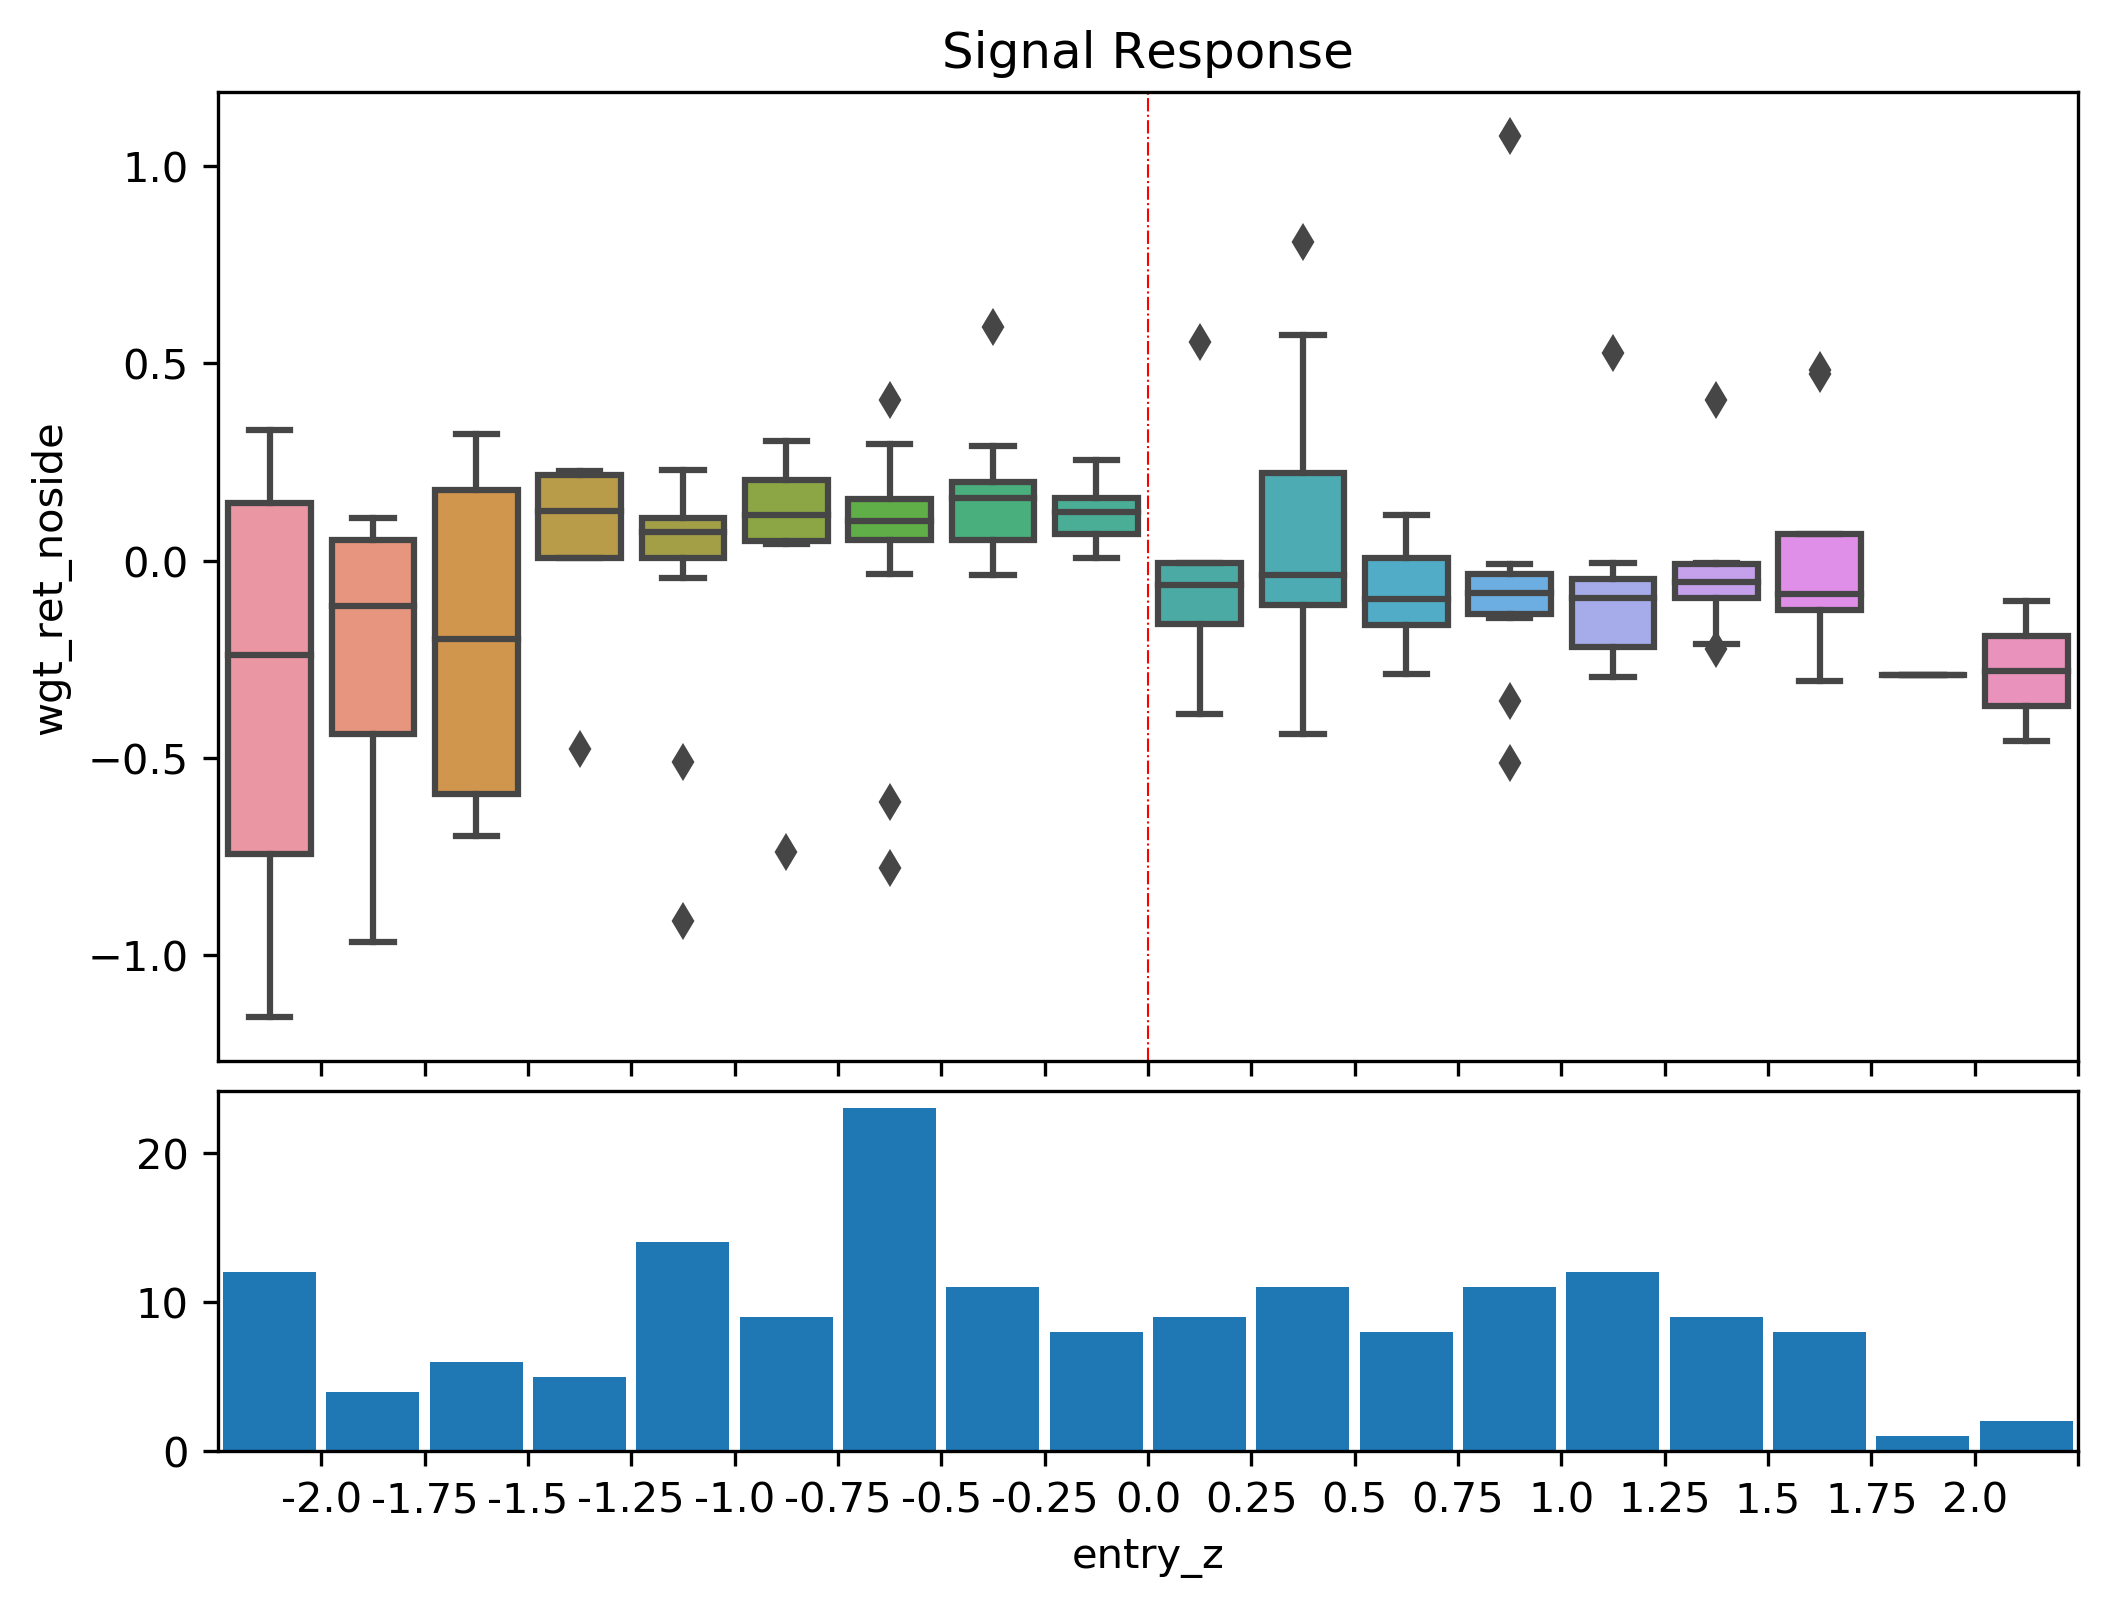

In [28]:
# Signal Response Plot
# Set thresholds to 0, so just the sign
# Used to evaluate whether larger signals are more valuable

# parameters
pos_agg_window = 13 #weeks
trade_len = 40 #days
pt_sl = (3,0.25)
norm_window = 26 #weeks
is_end_dt = dt.date(2018,1,1)
feat_adj = '_dv01'
filter_feat = 'LevFunds_dv01'
z_thresh_positions = 0.01
z_thresh_swap = 0.01
ct = 'US'
swap = CT_SWAP_MAP[ct][0]


# get data
r = get_rolling_cts(adj_ct_dfs, feat_adj, window=pos_agg_window, swap_chg_lags=[1], swap_chg_fwds=[1])
normed_pos = get_norm_cts(r, swaps, norm_window, swap_chg_fwds=[1])


signal_data = normed_pos[ct]
    
signal_data[swap] = signal_data[swap].subtract(signal_data[swap].rolling(norm_window).mean()).\
                                divide(signal_data[swap].rolling(norm_window).std())
swap_data = swaps.loc[:is_end_dt, swap]
swap_data_10yr_risk = (1. + swap_data.diff(1).fillna(0) / 10.).cumprod()

# build signals
signals_feat = zscore_signal(signal_data[filter_feat], z_thresh_positions, signal_type='Reversion')
signals_trailingcurve = zscore_signal(signal_data[swap], z_thresh_swap, signal_type='Momentum')
signals = signals_trailingcurve.to_frame().join(signals_feat)
signals['composed'] = signals.apply(lambda x: 0 if np.sign(x[filter_feat])!=np.sign(x[swap]) else x[filter_feat], axis=1)
signals['composed'].value_counts()

events0, df0 = zscore_sizing(signals['composed'], swap_data, vertbar=trade_len, pt_sl=pt_sl, even_weight=True)
events = generate_pnl(events0, swap_data_10yr_risk, pct_change=True)
events['entry_score'] = signal_data[filter_feat]
draw_signal_response(events, notch=False)

### Curve

In [29]:
# parameters
pos_agg_window = 5 #weeks
trade_len = 20 #days
pt_sl = (6,6)
norm_window = 26 #weeks
is_end_dt = dt.date(2021,1,1)
r = get_rolling_cts(adj_ct_dfs, feat_adj, window=pos_agg_window)
curve_diffs = get_norm_curve_diffs(curves, r, pos_agg_window, swaps, swap_chg_fwds=swap_chg_fwds, norm_window=norm_window)
daily_curves = get_daily_curve_diffs(curves, r, swaps)
filter_feat = 'LevFunds_dv01'
z_thresh_positions = 1.0
z_thresh_mom = 0.01
#windows = [3, 8, 13, 26]
curve = 'US-FV'
swap_curve = 'swap_US-5y'
signal_data = curve_diffs[curve].loc[:is_end_dt, [filter_feat, swap_curve]]
signal_data[swap_curve] = signal_data[swap_curve].subtract(signal_data[swap_curve].rolling(norm_window).mean()).\
                                divide(signal_data[swap_curve].rolling(norm_window).std())
swap_data = daily_curves.loc[:is_end_dt, swap_curve]
swap_data_10yr_risk = (1. + swap_data.diff(1).fillna(0) / 10.).cumprod()
# build signals
signals_feat = zscore_signal(signal_data[filter_feat], z_thresh_positions, signal_type='Reversion')
signals_trailingcurve = zscore_signal(signal_data[swap_curve], z_thresh_mom, signal_type='Momentum')
signals = signals_trailingcurve.to_frame().join(signals_feat)
signals['composed'] = signals.apply(lambda x: 0 if np.sign(x[filter_feat])!=np.sign(x[swap_curve]) else x[filter_feat], axis=1)
signals['composed'].value_counts()

C:\Users\Brendan\FinML\MLFin\ExPtTest\eptest_main.py:208: RuntimeWarning: invalid value encountered in sign
  new_df[fwdname + '_sign'] = np.sign(new_df[fwdname])
C:\Users\Brendan\FinML\MLFin\ExPtTest\eptest_main.py:292: RuntimeWarning: invalid value encountered in sign
  curve_diff[fwdname + '_sign'] = np.sign(curve_diff[fwdname])
C:\Users\Brendan\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in sign


 0.0    427
 1.0     56
-1.0     47
Name: composed, dtype: int64

C:\Users\Brendan\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\Brendan\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


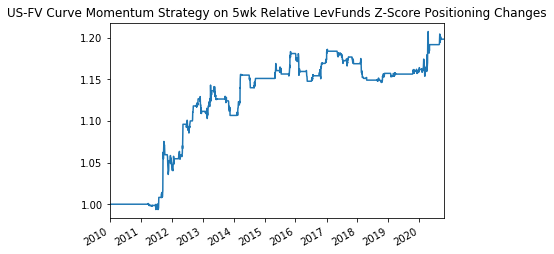

In [30]:
events0, df0 = zscore_sizing(signals['composed'], swap_data, vertbar=trade_len, pt_sl=pt_sl, even_weight=True)
events = generate_pnl(events0, swap_data_10yr_risk, pct_change=False)
mtm_pnl = generate_mtm_pnl(events, swap_data_10yr_risk, log_diff=True)
pnl_index = generate_pnl_index(mtm_pnl, None)

fig, ax = plt.subplots()
pnl_index.plot(ax=ax)
ax.set_title('US-FV Curve Momentum Strategy on 5wk Relative LevFunds Z-Score Positioning Changes')
plt.show()

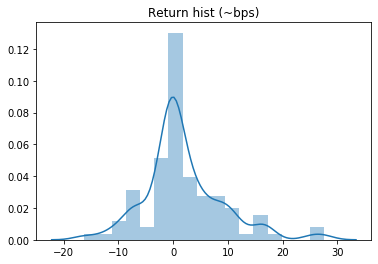

In [31]:
# Distribution of each trades pnl (not weighted by uniqueness, )
fig, ax = plt.subplots()
sns.distplot(events.ret*events.trgt*1000, ax=ax)
ax.set_title('Return hist (~bps)')
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

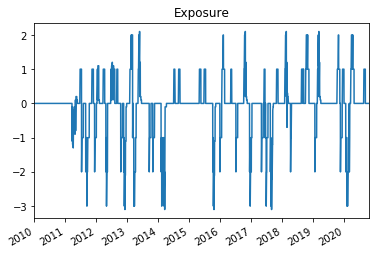

In [32]:
# Positions
exposures = generate_exposures(events, swap_data_10yr_risk)
fig, ax = plt.subplots()
exposures.plot(ax=ax)
ax.set_title('Exposure')
plt.show

In [33]:
# Performance summary stats
generate_perf_summary(events, swap_data_10yr_risk)

C:\Users\Brendan\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


Ann. Ret.                        0.0192832
Ann. Vol.                        0.0260829
Ann. Vol. (m)                    0.0281714
Sharpe                            0.739303
Sharpe (m)                        0.684495
Calmar                             0.52342
Max Drawdown                    -0.0368407
# Trades                                98
Avg. PnL                            0.0906
Long%Signals                      0.540816
Hit Ratio                         0.530612
Avg. Trade Days    18 days 15:11:01.224489
First Entry            2011-03-25 00:00:00
Last Exit              2020-09-10 00:00:00
dtype: object

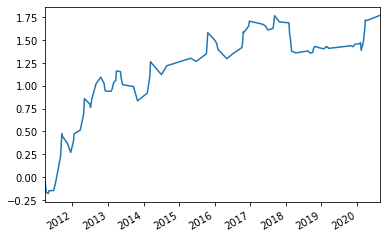

In [34]:
# dummy check
events_wpnl = events.merge(swap_data, left_index=True, right_index=True).merge(swap_data, left_on='t1', 
                                                                 right_index=True, suffixes=('_entry', '_exit'))
((events_wpnl['swap_US-5y_exit']-events_wpnl['swap_US-5y_entry']) * events_wpnl['side']).cumsum().plot()

# ToDo

## Data
### General
    - Check for general numerical issues
        - US June 2015 contract had a delivery gap of ~5yrs relative to March15 due to tsy issuance in early 2000s
        - see: https://www.cmegroup.com/trading/interest-rates/files/mar-15-jun-15-roll-analysis.pdf
        - the CTD MM swap then gets closer to the 20y... consider interpolating
    - Create offset series for Fridays, lets just shift it 3 days (data stamped tuesday but reported friday+ if holiday)
    - Split train+cv and full test data. Test data lets do 2018+
### Feature Generation:
Start evaluating training data visually, we need to work on stationary time series so let's do the transforms upfront:
        - DV01-weighted positions or % OI will be more informative, dur*px/100*ct_size/10000
        - Rolling x-week changes in transformed CoT data
            - Consider PCA of this CoT data and look at consistency of loadings over time
        - Rolling x-week changes in swap data
        - Indicator variables of whether the CoT change was 'same-way' as market move
    
    


## Modelling
### Feature Selection
Let's do feature selection second- random forest type feature importance algos, lasso
- First pass we can look at a few sets of x-lagged 1m changes(e.g. 1m lagged 1m changes, 2m lagged 1m changes, etc)
    
### Regression
Features need to be fit on a weekly basis- this data is weekly
- We could consider either modeling on Tuesday data or Friday, but need to evaluate residuals based on Friday
- Residual evaluation can be daily, not sure how valuable that'd be
Simple setups first
- lagged aggregated changes, including conditional on same way stuff
More complicated
- Maybe we do our own type of gridsearch CV with the parameter being the length of the window to aggregate changes

## Modelling
### Curve
- differences in rolling (raw and z-scored) increases to predict subsequent curve
    - construct all the pairwise combinations
    - compute features and targets
    - run the same process as above with outrights
- try predicting signs rather than regressions next
- (done) would have to implement our own gridsearchcv in order to use weighted scoring
- try SVC next

## Presentation
### Data
- general charts and correlation
- PCA views
- Regressions:
    - simple OLS to show knowledge about multicolinearity, etc
    - contemporaneous lasso regression- is there a consistent relationship (not really)
    - fwd looking lasso regression - can changes in positioning predict future yield changes
    - lasso based on cross validation
- Extreme value analysis:
    - If i normalize the position changes by a trailing z-score, what do avg subsequent changes in yield look like (plots)
    - Hit miss classification after extreme value filtering
        - bar charts of ADF p-values
        - accuracy vs lasso alpha plot
- (TODO) backtests of US/FV 
    - 'LevFunds', concurrent swap as features
    - z_filtered on LevFunds
    - logistic regression, accuracy scoring
    - rolling 5wk features and 20d predictions
    - composed with 
- (TODO) discussion of why I have low confidence, multiple testing bias

## Extra
Can we use some classification algorithms to filter when to trade or not to trade